In [1]:
import os
import json
import base64
import numpy as np
import pandas as pd
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog

# Query from Foursquare

In [11]:
import os
import json
import base64
import numpy as np
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog


def read_token(token_path: str) -> str:
    """
    Read and return the Foursquare API token from a local JSON file.

    The function supports two valid JSON formats:
    1) An object with a "token" key: {"token": "xxxxx"}
    2) A plain string containing the token: "xxxxx"

    Parameters
    ----------
    token_path : str
        Local file path to the JSON file containing the token.

    Returns
    -------
    str
        The token string extracted from the file.

    Raises
    ------
    ValueError
        If the JSON file format is invalid or does not contain a valid token.
    """
    with open(token_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "token" in data:
        return data["token"]
    if isinstance(data, str):
        return data
    raise ValueError("Token JSON must be either a string or an object with a key 'token'.")


def json_str_tr(x):
    """
    Convert non-JSON-serializable Python objects (e.g., lists, dicts, arrays)
    into string representations that can be safely exported or visualized.

    Parameters
    ----------
    x : Any
        The input value to be converted.

    Returns
    -------
    str or None
        The JSON-compatible string representation of the input value.
    """
    if x is None:
        return None
    elif isinstance(x, (str, int, float, bool)):
        return str(x)
    elif isinstance(x, (list, tuple, set, np.ndarray)):
        return str(list(x))
    elif isinstance(x, dict):
        return str({k: json_str_tr(v) for k, v in x.items()})
    elif isinstance(x, (bytes, bytearray)):
        return base64.b64encode(x).decode("ascii")
    else:
        return str(x)


def query_foursquare(
    token_path: str,
    minLon: float,
    maxLon: float,
    minLat: float,
    maxLat: float,
    limit_size: Optional[int] = None,
    table_name: str = "datasets.places_os",
    uri: str = "https://catalog.h3-hub.foursquare.com/iceberg",
    warehouse: str = "places",
):
    """
    Query Points of Interest (POIs) from the Foursquare Iceberg Catalog
    within a given geographic bounding box and return results as a GeoDataFrame.

    This function connects to the Foursquare H3-Hub Iceberg dataset, applies a spatial filter
    (latitude/longitude bounds), retrieves the data as a Pandas DataFrame, converts it into
    a GeoDataFrame (EPSG:4326), and ensures all complex fields are JSON-serializable.

    Parameters
    ----------
    token_path : str
        Path to the local JSON file containing the Foursquare API token.
        The file should follow one of these formats:
        - {"token": "xxxxx"}
        - "xxxxx"
    minLon, maxLon, minLat, maxLat : float
        Geographic bounding box coordinates (in WGS84) for the query.
    limit_size : int, optional
        Maximum number of rows to return. If None (default), returns all available rows.
    table_name : str, default "datasets.places_os"
        Name of the Iceberg table to query.
    uri : str, default "https://catalog.h3-hub.foursquare.com/iceberg"
        Base URI of the Foursquare Iceberg REST catalog.
    warehouse : str, default "places"
        Name of the warehouse used by the Iceberg catalog.

    Returns
    -------
    geopandas.GeoDataFrame
        A GeoDataFrame containing POI records with WGS84 geometry.

    Examples
    --------
    Limit to 5000 rows:
    >>> gdf = query_foursquare(
    ...     token_path="~/foursquare_token.json",
    ...     minLon=-119.8694, maxLon=-119.85346,
    ...     minLat=34.40887, maxLat=34.41727,
    ...     limit_size=5000
    ... )

    Retrieve all available records (no limit):
    >>> gdf = query_foursquare(
    ...     token_path="~/foursquare_token.json",
    ...     minLon=-119.8694, maxLon=-119.85346,
    ...     minLat=34.40887, maxLat=34.41727
    ... )
    """
    # --- Load token ---
    token = read_token(os.path.expanduser(token_path))

    # --- Connect to the Iceberg catalog ---
    catalog = load_catalog(
        "default",
        **{
            "warehouse": warehouse,
            "uri": uri,
            "token": token,
            "header.content-type": "application/vnd.api+json",
            "rest-metrics-reporting-enabled": "false",
        },
    )

    # --- Load target table ---
    table = catalog.load_table(table_name)

    # --- Define spatial filter ---
    expr = And(
        And(GreaterThanOrEqual("longitude", minLon), LessThanOrEqual("longitude", maxLon)),
        And(GreaterThanOrEqual("latitude", minLat), LessThanOrEqual("latitude", maxLat)),
    )

    # --- Run query ---
    df = table.scan(row_filter=expr, limit=limit_size).to_pandas()

    # --- Convert to GeoDataFrame ---
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326",
    )

    # --- Clean up non-serializable columns ---
    for col in gdf.columns:
        if col != "geometry":
            if gdf[col].apply(lambda x: isinstance(x, (list, dict, np.ndarray, bytes, bytearray))).any():
                gdf[col] = gdf[col].apply(json_str_tr)

    return gdf


In [18]:
# foursquare_places = query_foursquare(token_path="/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/foursquare_token.json",
#                        minLon=-119.8694, maxLon=-119.85346,
#                        minLat=34.40887, maxLat=34.41727)


# Query from Google Place API

In [ ]:
import math
import time
import json
import warnings
from typing import Optional, Iterable, List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# contextily is only needed for the web basemap
try:
    import contextily as ctx
    _HAS_CTX = True
except Exception:
    _HAS_CTX = False
    warnings.warn("⚠️ contextily not found, basemap will be skipped.")

import requests


def read_token(token_path: str) -> str:
    """
    Read and return the token from a local JSON file.

    The function supports two valid JSON formats:
    1) An object with a "token" key: {"token": "xxxxx"}
    2) A plain string containing the token: "xxxxx"

    Parameters
    ----------
    token_path : str
        Local file path to the JSON file containing the token.

    Returns
    -------
    str
        The token string extracted from the file.

    Raises
    ------
    ValueError
        If the JSON file format is invalid or does not contain a valid token.
    """
    with open(token_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "token" in data:
        return data["token"]
    if isinstance(data, str):
        return data
    raise ValueError("Token JSON must be either a string or an object with a key 'token'.")

def circle_center(
    min_lon: float,
    max_lon: float,
    min_lat: float,
    max_lat: float,
    R: float,
    base: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:
    """
    Generate a grid of circle polygons inside a geographic bounding box.
    Returns circles in EPSG:4326 (lon/lat).

    If `base` is provided, return only circles that intersect `base`
    (via spatial join, predicate='intersects').

    Parameters
    ----------
    min_lon, max_lon, min_lat, max_lat : float
        Bounding box in EPSG:4326.
    R : float
        Grid half-spacing in meters (in EPSG:3857). Spacing is 2R.
        Each circle radius is R * sqrt(2) in meters (in EPSG:3857).
    base : geopandas.GeoDataFrame | None
        A GeoDataFrame used to filter circles by intersection.
        Will be reprojected to EPSG:4326 if needed.

    Returns
    -------
    geopandas.GeoDataFrame
        Circles (filtered if base is provided), in EPSG:4326.
    """
    # -----------------------------
    # 0) Basic input validation
    # -----------------------------
    if not (isinstance(min_lon, (int, float)) and isinstance(max_lon, (int, float))
            and isinstance(min_lat, (int, float)) and isinstance(max_lat, (int, float))):
        raise TypeError("min_lon, max_lon, min_lat, max_lat must be numeric (float or int).")
    if not (max_lon > min_lon and max_lat > min_lat):
        raise ValueError("max_lon must be > min_lon and max_lat must be > min_lat.")
    if not (isinstance(R, (int, float)) and R > 0):
        raise ValueError("R must be a positive number (meters).")

    if base is not None:
        if not isinstance(base, gpd.GeoDataFrame):
            raise TypeError("base must be a GeoDataFrame or None.")
        if base.geometry is None:
            raise ValueError("base must have a valid geometry column.")
        if base.crs is None:
            raise ValueError("base.crs is None. Please set a CRS on base before using it.")

    # -----------------------------
    # 1) Build bbox in EPSG:4326
    # -----------------------------
    poly_4326 = box(min_lon, min_lat, max_lon, max_lat)
    gdf_bbox_4326 = gpd.GeoDataFrame({"name": ["bbox_4326"]}, geometry=[poly_4326], crs="EPSG:4326")

    # -----------------------------
    # 2) Reproject bbox to EPSG:3857 (meters)
    # -----------------------------
    gdf_bbox_3857 = gdf_bbox_4326.to_crs(epsg=3857)
    minx, miny, maxx, maxy = gdf_bbox_3857.total_bounds

    # -----------------------------
    # 3) Grid centers inside bbox
    # -----------------------------
    xs = np.arange(minx + R, maxx + 1e-9, 2 * R)
    ys = np.arange(miny + R, maxy + 1e-9, 2 * R)

    if xs.size == 0 or ys.size == 0:
        warnings.warn("⚠️ No grid centers generated — check if R is too large or bbox too small.")
        centers_xy = np.empty((0, 2))
    else:
        xx, yy = np.meshgrid(xs, ys)
        centers_xy = np.column_stack([xx.ravel(), yy.ravel()])

    # -----------------------------
    # 4) Build circles in 3857 -> back to 4326
    # -----------------------------
    radius_m = R * math.sqrt(2.0)
    circles_3857 = [Point(cx, cy).buffer(radius_m, resolution=64) for (cx, cy) in centers_xy]
    circles = gpd.GeoDataFrame(geometry=circles_3857, crs="EPSG:3857").to_crs(epsg=4326)

    # -----------------------------
    # 5) Optional: filter circles by intersection with base
    # -----------------------------
    base_4326 = base.to_crs("EPSG:4326")
    circles_4326 = (
        gpd.sjoin(circles, base_4326, how="inner", predicate="intersects")
            .reset_index(drop=True)
    )
    circles_4326 = circles_4326[circles.columns]
    return circles_4326


def places_nearby_grid(
    circles_4326: gpd.GeoDataFrame,
    token: str,
    *,
    radius_m: float,
    max_result_count: int = 20,         # per page, Google allows up to 20 for v1 nearby
    max_pages_per_center: int = 3,      # safety cap for pagination
    page_sleep_sec: float = 1.5,        # small wait between pages; Google may need a short delay
    included_primary_types: Optional[List[str]] = None,
    excluded_primary_types: Optional[List[str]] = None,
    extra_fieldmask: Optional[Iterable[str]] = None,
) -> gpd.GeoDataFrame:
    """
    Query Google Places API v1 `places:searchNearby` for each circle center (centroid) and
    concatenate all results into one pandas DataFrame. Handles pagination automatically.

    Parameters
    ----------
    circles : GeoDataFrame
        A GeoDataFrame of circle polygons in EPSG:4326. The centroid of each polygon will be used
        as the query center (lat/lon) for the Places request.
    token : str
        Google Maps Platform API key (Places API enabled).
    radius_m : float
        Search radius in meters, applied to every query (per circle) = R.np.squart(2.0).
    max_result_count : int, default 20
        Number of results per page. Google Nearby v1 typically returns up to 20 per page.
    max_pages_per_center : int, default 3
        Maximum number of pages to fetch for each centroid to avoid unbounded loops.
    page_sleep_sec : float, default 1.5
        Sleep time between page fetches. Some nextPageTokens require a brief delay to become valid.
    included_primary_types : list[str] or None
        If provided, send as `includedPrimaryTypes` in request JSON.
    excluded_primary_types : list[str] or None
        If provided, send as `excludedPrimaryTypes` in request JSON.
    extra_fieldmask : Iterable[str] or None
        Extra fields to request. Base fields are included; you can append more here.

    Returns
    -------
    geopandas.GeoDataFrame
        A GeoDataFrame of all places found across all circle centers with columns:
        ['id','name','address','category','lat','lon','geometry'].
        Duplicates are dropped by `id` (keep='first').
        
    How to run:
    -------
    excluded = [
        "apartment_building",
        "apartment_complex",
        "condominium_complex",
        "housing_complex",
    ]

    gdf_places = places_nearby_grid(
        circles=circles,
        token=token,
        radius_m=R * math.sqrt(2.0),     # Use your R value, or the radius of each circle
        max_result_count=20,           # Up to 20 per page
        max_pages_per_center=3,        # Up to 3 pages per center (for safety)
        page_sleep_sec=0.1,            # Wait 2 seconds before next page
        included_primary_types=None,   # e.g., ["restaurant"]
        excluded_primary_types=excluded,
        extra_fieldmask=None           # If you want more fields, pass a list here
    )
        
    """

    url = "https://places.googleapis.com/v1/places:searchNearby"
    base_fields = [
        "places.id",
        "places.displayName",
        "places.formattedAddress",
        "places.location",
        "places.primaryType",
    ]
    if extra_fieldmask:
        base_fields.extend(list(extra_fieldmask))

    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": token,
        "X-Goog-FieldMask": ",".join(base_fields),
    }

    # -----------------------------
    # 0) Get centroids for query points（calculating by crs 3857 and then transfer to 4326）
    # -----------------------------
    circles_m = circles_4326.to_crs(epsg=3857)
    centroids_m = circles_m.geometry.centroid
    centroids = gpd.GeoSeries(centroids_m, crs="EPSG:3857").to_crs(epsg=4326)
    centers = list(zip(centroids.y, centroids.x))  # (lat, lon)


    # -----------------------------
    # 1) Collect included & excluded POI type
    # -----------------------------
    included_primary_types = list(included_primary_types or [])
    excluded_primary_types = list(excluded_primary_types or [])


    # -----------------------------
    # 2) Interatively query from google places
    # -----------------------------
    rows: List[Dict[str, Any]] = []
    with requests.Session() as sess:
        for idx, (lat, lon) in enumerate(centers):
            payload_base = {
                "locationRestriction": {
                    "circle": {
                        "center": {"latitude": float(lat), "longitude": float(lon)},
                        "radius": float(radius_m),
                    }
                },
                "maxResultCount": int(max_result_count),
            }
            if included_primary_types:
                payload_base["includedPrimaryTypes"] = included_primary_types
            if excluded_primary_types:
                payload_base["excludedPrimaryTypes"] = excluded_primary_types

            next_page_token = None
            page_count = 0

            while True:
                page_count += 1
                payload = dict(payload_base)
                if next_page_token:
                    payload["pageToken"] = next_page_token

                r = sess.post(url, headers=headers, json=payload, timeout=30)
                if r.status_code != 200:
                    print(f"❌ HTTP {r.status_code} at center {idx} ({lat:.6f},{lon:.6f}): {r.text}")
                    break

                data = r.json() or {}
                places = data.get("places", [])
                for p in places:
                    rows.append(
                        {
                            "id": p.get("id"),
                            "name": (p.get("displayName") or {}).get("text"),
                            "address": p.get("formattedAddress"),
                            "category": p.get("primaryType"),
                            "lat": (p.get("location") or {}).get("latitude"),
                            "lon": (p.get("location") or {}).get("longitude"),
                        }
                    )

                next_page_token = data.get("nextPageToken") or data.get("next_page_token")
                if not next_page_token or page_count >= max_pages_per_center:
                    break
                time.sleep(page_sleep_sec)

    df = pd.DataFrame(rows)
    if df.empty:
        return gpd.GeoDataFrame(df, geometry=[], crs="EPSG:4326")

    # -----------------------------
    # 3) Delete duplicate POI points and transfer dataframe into geodataframe
    # -----------------------------
    df = df.drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)
    df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
    df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
    df = df.dropna(subset=["lat", "lon"])

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
    return gdf


def google_places_grid_search(
    min_lon: float,
    max_lon: float,
    min_lat: float,
    max_lat: float,
    R: float,
    base: gpd.GeoDataFrame,
    token: str,
    show_plot: bool = False,
    basemap_zoom: int = 17,
    basemap_provider: Optional[object] = None,
    max_result_count: int = 20,
    max_pages_per_center: int = 3,
    page_sleep_sec: float = 1.5,
    included_primary_types: Optional[List[str]] = None,
    excluded_primary_types: Optional[List[str]] = None,
    extra_fieldmask: Optional[Iterable[str]] = None,
) -> gpd.GeoDataFrame:
    """
    Unified entry function: Generate circle grid → Query Google Places v1:searchNearby → Visualize results.

    Parameters
    ----
    - min_lon, max_lon, min_lat, max_lat: Bounding box in EPSG:4326 coordinates (longitude/latitude).
    - R: Half grid spacing in meters (grid step = 2R, each circle radius = R * sqrt(2)).
    - base: GeoDataFrame to filter circles by intersection (in EPSG:4326).
    - token: Google Maps Platform API key (Places API must be enabled).
    - show_plot: Whether to visualize the result (red = bounding box, light blue = circles, red = POIs).
    - basemap_zoom, basemap_provider: Basemap settings (require contextily to display).
    - max_result_count, max_pages_per_center, page_sleep_sec: Pagination and throttling settings for Places API requests.
    - included_primary_types, excluded_primary_types, extra_fieldmask: Category filters and additional fields to request.

    How to run:
    ----
    # === Define Input parameter ===
    min_lon, max_lon = -119.8694, -119.85346
    min_lat, max_lat = 34.40887, 34.41727
    R = 100  #  m
    token = read_token("/path/googleplace_token.json")

    excluded = [
        "apartment_building",
        "apartment_complex",
        "condominium_complex",
        "housing_complex",
    ]

    gdf_places = google_places_grid_search(
        min_lon=min_lon,
        max_lon=max_lon,
        min_lat=min_lat,
        max_lat=max_lat,
        R=R,
        token=token,
        show_plot=True,
        basemap_zoom=17,
        basemap_provider=None,         # default Esri.WorldImagery
        max_result_count=20,
        max_pages_per_center=3,
        page_sleep_sec=1.5,
        included_primary_types=None,   # ex ["restaurant"]
        excluded_primary_types=excluded,
        extra_fieldmask=None           # can add more field
    )

    Returns
    ----
      - gdf_places_4326: GeoDataFrame of POI points in EPSG:4326 (longitude/latitude).
      - plot figure(option)
    """
    # -----------------------------
    # 1) Generate circle grid
    # -----------------------------
    gdf_circles = circle_center(
        min_lon=min_lon,
        max_lon=max_lon,
        min_lat=min_lat,
        max_lat=max_lat,
        R=R,
        base=base
    )

    # -----------------------------
    # 2) Query Google Places v1:searchNearby
    # -----------------------------
    radius_m = R * math.sqrt(2.0)
    gdf_places = places_nearby_grid(
        circles_4326=gdf_circles,
        token=token,
        radius_m=radius_m,
        max_result_count=max_result_count,
        max_pages_per_center=max_pages_per_center,
        page_sleep_sec=page_sleep_sec,
        included_primary_types=included_primary_types,
        excluded_primary_types=excluded_primary_types,
        extra_fieldmask=extra_fieldmask,
    )

    # -----------------------------
    # 3) Visualize results
    # -----------------------------
    if show_plot:
        bbox_4326 = gpd.GeoDataFrame(
            geometry=[box(min_lon, min_lat, max_lon, max_lat)],
            crs="EPSG:4326",
        )
        bbox_3857 = bbox_4326.to_crs(epsg=3857)
        circles_3857 = gdf_circles.to_crs(epsg=3857)
        places_3857 = gdf_places.to_crs(epsg=3857) if not gdf_places.empty else gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")

        fig, ax = plt.subplots(figsize=(12, 12))
        bbox_3857.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
        circles_3857.plot(ax=ax, edgecolor="blue", facecolor="lightblue", alpha=0.35, linewidth=0.8)
        places_3857.plot(ax=ax, markersize=12, color="red", alpha=0.8)

        xmin, ymin, xmax, ymax = bbox_3857.total_bounds
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

        if _HAS_CTX:
            provider = basemap_provider or ctx.providers.Esri.WorldImagery
            try:
                ctx.add_basemap(ax, source=provider, zoom=basemap_zoom)
            except Exception as e:
                warnings.warn(f"⚠️ Basemap failed to load: {e}")

        handles = [
            Patch(facecolor='none', edgecolor='red', linewidth=2, label='Bounding Box'),
            Patch(facecolor='lightblue', edgecolor='blue', alpha=0.5, label='Circles'),
        ]
        if not gdf_places.empty:
            poi_handle = plt.Line2D([0], [0], marker='o', linestyle='None', markersize=6, color='red', label='POIs')
            handles.append(poi_handle)

        ax.legend(handles=handles, loc='upper left')
        ax.set_axis_off()
        ax.set_title("BBox + Circle Grid + Google Places", fontsize=14)
        plt.tight_layout()
        plt.show()

    return gdf_places

In [ ]:
# # === Define Input parameter ===
# min_lon, max_lon = -75.195498, -71.777492
# min_lat, max_lat = 39.475206, 41.527202
# R = 10000  #  m
# token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

# excluded = [
#     "apartment_building",
#     "apartment_complex",
#     "condominium_complex",
#     "housing_complex",
# ]

# google_places_100 = google_places_grid_search(
#     min_lon=min_lon,
#     max_lon=max_lon,
#     min_lat=min_lat,
#     max_lat=max_lat,
#     R=R,
#     base=msa_ny,
#     token=token,
#     show_plot=False,
#     basemap_zoom=17,
#     basemap_provider=None,         # default Esri.WorldImagery
#     max_result_count=20,
#     max_pages_per_center=3,
#     page_sleep_sec=1.5,
#     included_primary_types=None,   # ex ["restaurant"]
#     excluded_primary_types=excluded,
#     extra_fieldmask=None           # can add more field
# )

In [13]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "car_dealer",
    "car_rental",
    "car_repair",
    "car_wash",
    "electric_vehicle_charging_station",
    "gas_station",
    "parking",
    "rest_stop",
]

google_automotive_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    token=token,
    base=msa_ny,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [16]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "corporate_office",
    "farm",
    "ranch",
]

google_business_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    token=token,
    base=msa_ny,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [19]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "art_gallery",
    "art_studio",
    "auditorium",
    "cultural_landmark",
    "historical_place",
    "monument",
    "museum",
    "performing_arts_theater",
    "sculpture",
]

google_culture_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [20]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "library",
    "preschool",
    "primary_school",
    "school",
    "secondary_school",
    "university",
]

google_education_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [23]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "adventure_sports_center",
    "amphitheatre",
    "amusement_center",
    "amusement_park",
    "aquarium",
    "banquet_hall",
    "barbecue_area",
    "botanical_garden",
    "bowling_alley",
    "casino",
    "childrens_camp",
    "comedy_club",
    "community_center",
    "concert_hall",
    "convention_center",
    "cultural_center",
    "cycling_park",
    "dance_hall",
    "dog_park",
    "event_venue",
    "ferris_wheel",
    "garden",
    "hiking_area",
    "historical_landmark",
    "internet_cafe",
    "karaoke",
    "marina",
    "movie_rental",
    "movie_theater",
    "national_park",
    "night_club",
    "observation_deck",
    "off_roading_area",
    "opera_house",
    "park",
    "philharmonic_hall",
    "picnic_ground",
    "planetarium",
    "plaza",
    "roller_coaster",
    "skateboard_park",
    "state_park",
    "tourist_attraction",
    "video_arcade",
    "visitor_center",
    "water_park",
    "wedding_venue",
    "wildlife_park",
    "wildlife_refuge",
    "zoo",
]

google_entertainment_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [ ]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "public_bath",
    "public_bathroom",
    "stable",
]

google_facilities_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [27]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "accounting",
    "atm",
    "bank",
]

google_finance_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [28]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "acai_shop",
    "afghani_restaurant",
    "african_restaurant",
    "american_restaurant",
    "asian_restaurant",
    "bagel_shop",
    "bakery",
    "bar",
    "bar_and_grill",
    "barbecue_restaurant",
    "brazilian_restaurant",
    "breakfast_restaurant",
    "brunch_restaurant",
    "buffet_restaurant",
    "cafe",
    "cafeteria",
    "candy_store",
    "cat_cafe",
    "chinese_restaurant",
    "chocolate_factory",
    "chocolate_shop",
    "coffee_shop",
    "confectionery",
    "deli",
    "dessert_restaurant",
    "dessert_shop",
    "diner",
    "dog_cafe",
    "donut_shop",
    "fast_food_restaurant",
    "fine_dining_restaurant",
    "food_court",
]

google_food1_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [29]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "french_restaurant",
    "greek_restaurant",
    "hamburger_restaurant",
    "ice_cream_shop",
    "indian_restaurant",
    "indonesian_restaurant",
    "italian_restaurant",
    "japanese_restaurant",
    "juice_shop",
    "korean_restaurant",
    "lebanese_restaurant",
    "meal_delivery",
    "meal_takeaway",
    "mediterranean_restaurant",
    "mexican_restaurant",
    "middle_eastern_restaurant",
    "pizza_restaurant",
    "pub",
    "ramen_restaurant",
    "restaurant",
    "sandwich_shop",
    "seafood_restaurant",
    "spanish_restaurant",
    "steak_house",
    "sushi_restaurant",
    "tea_house",
    "thai_restaurant",
    "turkish_restaurant",
    "vegan_restaurant",
    "vegetarian_restaurant",
    "vietnamese_restaurant",
    "wine_bar",
]

google_food2_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [30]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "city_hall",
    "courthouse",
    "embassy",
    "fire_station",
    "government_office",
    "local_government_office",
    "police",
    "post_office",
]

google_government_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [31]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "chiropractor",
    "dental_clinic",
    "dentist",
    "doctor",
    "drugstore",
    "hospital",
    "massage",
    "medical_lab",
    "pharmacy",
    "physiotherapist",
    "sauna",
    "skin_care_clinic",
    "spa",
    "tanning_studio",
    "wellness_center",
    "yoga_studio",
]

google_health_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [32]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "beach",
]

google_nature_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [33]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "church",
    "hindu_temple",
    "mosque",
    "synagogue",
]

google_places_worship_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [34]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "astrologer",
    "barber_shop",
    "beautician",
    "beauty_salon",
    "body_art_service",
    "catering_service",
    "cemetery",
    "child_care_agency",
    "consultant",
    "courier_service",
    "electrician",
    "florist",
    "food_delivery",
    "foot_care",
    "funeral_home",
    "hair_care",
    "hair_salon",
    "insurance_agency",
    "laundry",
    "lawyer",
    "locksmith",
    "makeup_artist",
    "moving_company",
    "nail_salon",
    "painter",
    "plumber",
    "psychic",
    "real_estate_agency",
    "roofing_contractor",
    "storage",
    "summer_camp_organizer",
    "tailor",
    "telecommunications_service_provider",
    "tour_agency",
    "tourist_information_center",
    "travel_agency",
    "veterinary_care",
]

google_services_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [14]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "asian_grocery_store",
    "auto_parts_store",
    "bicycle_store",
    "book_store",
    "butcher_shop",
    "cell_phone_store",
    "clothing_store",
    "convenience_store",
    "department_store",
    "discount_store",
    "electronics_store",
    "food_store",
    "furniture_store",
    "gift_shop",
    "grocery_store",
    "hardware_store",
    "home_goods_store",
    "home_improvement_store",
    "jewelry_store",
    "liquor_store",
    "market",
    "pet_store",
    "shoe_store",
    "shopping_mall",
    "sporting_goods_store",
    "store",
    "supermarket",
    "warehouse_store",
    "wholesaler",
]

google_shop_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)

In [7]:
google_shop_100

,id,name,address,category,lat,lon,geometry
0,ChIJ1XpcHfoCwYkR7XNgemLFE94,Walmart Supercenter,"631 US-9, Little Egg Harbor Township, NJ 08087...",department_store,39.603383,-74.363329,POINT (-74.36333 39.60338)
1,ChIJixfmJNTlwIkRnyO8U4Hu0Ws,ShopRite of Galloway,"401 S Pitney Rd, Galloway, NJ 08205, USA",grocery_store,39.462756,-74.495488,POINT (-74.49549 39.46276)
2,ChIJ3T9I49oDwYkRvuTcE1oYEMg,Tractor Supply Co.,"630 US-9, Little Egg Harbor Township, NJ 08087...",store,39.600825,-74.363547,POINT (-74.36355 39.60082)
3,ChIJ0xCGpXvkwIkRI1wmjpqvFIg,Smithville Peanut Butter Company,"615 E Moss Mill Rd #55, Smithville, NJ 08205, USA",store,39.495509,-74.461318,POINT (-74.46132 39.49551)
4,ChIJTX3daXYEwYkRDf8RO2Po9v0,Shooters Hardware,"218 Main St, West Creek, NJ 08092, USA",sporting_goods_store,39.635120,-74.306459,POINT (-74.30646 39.63512)
...,...,...,...,...,...,...,...
1842,ChIJRQuKuRD554kRVmNuzHf03QI,Costco Wholesale,"200 Federal Rd, Brookfield, CT 06804, USA",warehouse_store,41.441932,-73.406437,POINT (-73.40644 41.44193)
1843,ChIJYRQJTKL354kRAHmqK4OMTAQ,Elephant's Trunk Flea Market,"490 Danbury Rd, New Milford, CT 06776, USA",market,41.521877,-73.423450,POINT (-73.42345 41.52188)
1844,ChIJIwBPNyL554kRlvgcPoGIPBA,BJ's Wholesale Club,"106 Federal Rd, Brookfield, CT 06804, USA",store,41.437779,-73.410842,POINT (-73.41084 41.43778)
1845,ChIJZ39sPl_254kR1M5aZf_I6ks,Walmart,"164 Danbury Rd, New Milford, CT 06776, USA",department_store,41.551945,-73.419794,POINT (-73.41979 41.55194)


In [36]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "arena",
    "athletic_field",
    "fishing_charter",
    "fishing_pond",
    "fitness_center",
    "golf_course",
    "gym",
    "ice_skating_rink",
    "playground",
    "ski_resort",
    "sports_activity_location",
    "sports_club",
    "sports_coaching",
    "sports_complex",
    "stadium",
    "swimming_pool",
]

google_sport_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [37]:
# === Define Input parameter ===
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  #  m
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")

excluded = [
    "apartment_building",
    "apartment_complex",
    "condominium_complex",
    "housing_complex",
]

include = [
    "airport",
    "airstrip",
    "bus_station",
    "bus_stop",
    "ferry_terminal",
    "heliport",
    "international_airport",
    "light_rail_station",
    "park_and_ride",
    "subway_station",
    "taxi_stand",
    "train_station",
    "transit_depot",
    "transit_station",
    "truck_stop",
]

google_transportation_100 = google_places_grid_search(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny,
    token=token,
    show_plot=False,
    basemap_zoom=17,
    basemap_provider=None,         # default Esri.WorldImagery
    max_result_count=20,
    max_pages_per_center=3,
    page_sleep_sec=1.5,
    included_primary_types=include,   # ex ["restaurant"]
    excluded_primary_types=excluded,
    extra_fieldmask=None           # can add more field
)


In [38]:
datasets = {
    "automotive": google_automotive_100,
    "business": google_business_100,
    "culture": google_culture_100,
    "education": google_education_100,
    "entertainment": google_entertainment_100,
    "facilities": google_facilities_100,
    "finance": google_finance_100,
    "food": google_food1_100,
    "food": google_food2_100,
    "government": google_government_100,
    "health": google_health_100,
    "nature": google_nature_100,
    "worship": google_places_worship_100,
    "services": google_services_100,
    "shop": google_shop_100,
    "sport": google_sport_100,
    "transportation": google_transportation_100,
}

# Add primary_cat to each GeoDataFrame
for cat, gdf in datasets.items():
    gdf["primary_cat"] = cat

google_placescat_100 = gpd.GeoDataFrame(
    pd.concat(list(datasets.values()), ignore_index=True),
    crs=google_automotive_100.crs
)
google_placescat_100 = google_placescat_100.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

In [40]:
google_placescat_100

,id,name,address,category,lat,lon,geometry,primary_cat
0,ChIJq4I4GHYEwYkRPnNQFayP8_M,Sunoco Gas Station,"1520 County Rd 539, Tuckerton, NJ 08087, USA",gas_station,39.648464,-74.342497,POINT (-74.34250 39.64846),automotive
1,ChIJObBMPsHlwIkRuy444QAfNDc,500 East Fairway Lane Parking,"500 E Fairway Ln, Galloway, NJ 08205, USA",parking,39.448611,-74.480219,POINT (-74.48022 39.44861),automotive
2,ChIJS32dTovmwIkRwT-HeWnlCUY,Sunoco,"17 E Jimmie Leeds Rd, Galloway, NJ 08205, USA",gas_station,39.474179,-74.522572,POINT (-74.52257 39.47418),automotive
3,ChIJrakeEBIdwYkRkZcjpopHcUQ,Conoco,"5601 US-9, New Gretna, NJ 08224, USA",gas_station,39.591041,-74.460875,POINT (-74.46087 39.59104),automotive
4,ChIJz7hkD1ADwYkRtN8bVbUUF1I,AutoZone Auto Parts,"409 US-9, Little Egg Harbor Township, NJ 08087...",auto_parts_store,39.601971,-74.354841,POINT (-74.35484 39.60197),automotive
...,...,...,...,...,...,...,...,...
23737,ChIJGay5JXy0wokR_oD97jpq4QI,Route 6 @ Mahopac Village Center,"Mahopac, NY 10541, USA",bus_stop,41.347963,-73.754142,POINT (-73.75414 41.34796),transportation
23738,ChIJ4aKDlA5X3YkRjBvkwvIcC6Y,Ball Pond Firehouse Park & Ride,"7 Fairfield Dr, New Fairfield, CT 06812, USA",park_and_ride,41.456849,-73.528357,POINT (-73.52836 41.45685),transportation
23739,ChIJU23Az-r754kRPoN0bXN1bRE,Park & Ride,"Barnabas Rd, Newtown, CT 06470, USA",park_and_ride,41.427606,-73.354741,POINT (-73.35474 41.42761),transportation
23740,ChIJ_WHGPx3254kRpj415GYebao,Candlelight Farms Airport-11N,"5 Green Pond Rd, Sherman, CT 06784, USA",airstrip,41.567657,-73.459808,POINT (-73.45981 41.56766),transportation


In [39]:
google_placescat_100.to_file('/Users/houpuli/Downloads/google_placescat_10000.geojson', driver="GeoJSON")

In [21]:
# google_places_100 = google_places_100.merge(google_placescat_100[['id','primary_cat']], on = 'id', how = 'left')
# google_places_100

# A little comparison between Foursqure, Google and Overture

In [2]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [3]:
google_placescat_100 = gpd.read_file(r'/Users/houpuli/Downloads/google_placescat_100.geojson')
google_placescat_100['addr'] = (
    google_placescat_100['address']
    .str.lower()
    .str.replace(", usa", "", regex=False)   
    .str.replace(" usa", "", regex=False)
    .str.strip()
)
google_placescat_100['match_key'] = (google_placescat_100['addr'] + "," + google_placescat_100['name']).str.lower().str.strip()
trans = {
    "automotive": "Automotive",
    "business": "Business",
    "culture": "Culture",
    "education": "Education",
    "entertainment": "Entertainment and Recreation",
    "facilities": "Facilities",
    "finance": "Finance",
    "food": "Food and Drink",
    "government": "Government",
    "health": "Health and Wellness",
    "nature": "Natural Features",
    "worship": "Places of Worship",
    "services": "Services",
    "shop": "Shopping",
    "sport": "Sports",
    "transportation": "Transportation",
}
google_placescat_100["primary_cat"] = google_placescat_100["primary_cat"].map(trans)
google_placescat_100

,id,name,address,category,lat,lon,primary_cat,geometry,addr,match_key
0,ChIJiw5WUGk_6YARZCQ1NeOksK8,UCSB Parking Lot 24,"Ocean Rd, Santa Barbara, CA 93106, USA",parking,34.410612,-119.853158,Automotive,POINT (-119.85316 34.41061),"ocean rd, santa barbara, ca 93106","ocean rd, santa barbara, ca 93106,ucsb parking..."
1,ChIJMc-MEWg_6YAR6YO-uKn7Pqg,Downtown IV Parking Lot,"871-901 Embarcadero del Mar, Isla Vista, CA 93...",parking,34.413360,-119.857322,Automotive,POINT (-119.85732 34.41336),"871-901 embarcadero del mar, isla vista, ca 93117","871-901 embarcadero del mar, isla vista, ca 93..."
2,ChIJ5_sbDmg_6YAR2PZtxrkw1NA,PowerFlex Charging Station,"881 Embarcadero del Mar, Isla Vista, CA 93117,...",electric_vehicle_charging_station,34.413398,-119.857383,Automotive,POINT (-119.85738 34.41340),"881 embarcadero del mar, isla vista, ca 93117","881 embarcadero del mar, isla vista, ca 93117,..."
3,ChIJUTwv-mg_6YARPvCj9QNwcdc,Nespor's University Auto House,"924 Embarcadero del Norte, Goleta, CA 93117, USA",car_repair,34.412649,-119.855095,Automotive,POINT (-119.85510 34.41265),"924 embarcadero del norte, goleta, ca 93117","924 embarcadero del norte, goleta, ca 93117,ne..."
4,ChIJjWbCzmg_6YAR7HIgB_rk7UI,ChargePoint Charging Station,"University of California, Santa Barbara, 22 Pa...",electric_vehicle_charging_station,34.413556,-119.853075,Automotive,POINT (-119.85307 34.41356),"university of california, santa barbara, 22 pa...","university of california, santa barbara, 22 pa..."
...,...,...,...,...,...,...,...,...,...,...
207,ChIJlxP_ZGc_6YARLPBboytlmew,El Colegio & Embarcadero Del Mar,"Isla Vista, CA 93117, USA",bus_stop,34.417241,-119.857850,Transportation,POINT (-119.85785 34.41724),"isla vista, ca 93117","isla vista, ca 93117,el colegio & embarcadero ..."
208,ChIJdyxgb2c_6YARr6C1C19wCWw,El Colegio & Embarcadero Del Mar,"California 93117, USA",transit_station,34.417369,-119.857653,Transportation,POINT (-119.85765 34.41737),california 93117,"california 93117,el colegio & embarcadero del mar"
209,ChIJOT5Z9WY_6YARuU6mXffZodc,El Colegio & Stadium,"University of California-Santa Barbara, CA 931...",bus_stop,34.417475,-119.854100,Transportation,POINT (-119.85410 34.41748),"university of california-santa barbara, ca 93117","university of california-santa barbara, ca 931..."
210,ChIJVaUrcGY_6YARZnkQKZ6yq5A,El Colegio & Stadium,"University of California-Santa Barbara, CA 931...",bus_stop,34.416898,-119.853300,Transportation,POINT (-119.85330 34.41690),"university of california-santa barbara, ca 93117","university of california-santa barbara, ca 931..."


In [4]:
fsq_table = pd.read_csv("https://raw.githubusercontent.com/HOUPU1993/POI-study/main/places-and-apiv3-categories.csv")
split_cols = fsq_table["Category Label"].str.split(">", expand=True)
split_cols = split_cols.apply(lambda col: col.str.strip())
split_cols.columns = [f"level_{i+1}" for i in range(split_cols.shape[1])]
fsq_table = pd.concat([fsq_table, split_cols], axis=1)

fsq_to_google_map = {
    "Arts and Entertainment": "Entertainment and Recreation",
    "Business and Professional Services": "Business",
    "Community and Government": "Government",
    "Dining and Drinking": "Food and Drink",
    "Event": "Entertainment and Recreation",
    "Health and Medicine": "Health and Wellness",
    "Landmarks and Outdoors": "Natural Features",
    "Retail": "Shopping",
    "Sports and Recreation": "Sports",
    "Travel and Transportation": "Transportation",
}

fsq_table["google_category"] = fsq_table["level_1"].map(fsq_to_google_map)
fsq_table = fsq_table[['Category ID','Category Label','google_category']]

foursquare_places = gpd.read_file(r'/Users/houpuli/Downloads/untitled folder 5/places_os.geojson')
foursquare_places = foursquare_places[~foursquare_places['address'].isnull()].reset_index(drop=True)
foursquare_places['addr'] = (
    foursquare_places['address'].fillna('') + ", " +
    foursquare_places['locality'].fillna('') + ", " +
    foursquare_places['region'].fillna('') + " " +
    foursquare_places['postcode'].fillna('')
)
foursquare_places['addr'] = (
    foursquare_places['addr']
    .str.lower()
    .str.replace(r'\s+,', ',', regex=True)   
    .str.strip(', ')                         
)
foursquare_places = foursquare_places.rename(columns={'fsq_place_id': 'id'})
foursquare_places = foursquare_places[~foursquare_places['fsq_category_labels'].isnull()].reset_index(drop=True)
foursquare_places['match_key'] = (foursquare_places['addr'] + "," + foursquare_places['name']).str.lower().str.strip()
foursquare_places["fsq_category_labels"] = (
    foursquare_places["fsq_category_labels"]
    .apply(lambda x: x[0] if isinstance(x, list) else x)   # list → string
    .astype(str)
    .str.strip("[]")
    .str.strip()
)
foursquare_places = foursquare_places.merge(
    fsq_table[["Category Label", "google_category"]],
    left_on="fsq_category_labels",
    right_on="Category Label",
    how="left"
).drop(columns={'Category Label'})
foursquare_places

,id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,geometry,addr,match_key,google_category
0,4d7a85248e775941ea29453a,Danger Cliff,34.409422,-119.859084,6607 Del Playa Dr,Goleta,CA,93117,NaN,NaN,...,[4bf58dd8d48988d162941735],Landmarks and Outdoors > Other Great Outdoors,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfb7O3a2LUBBNGfz0AzB,"{'xmin': '-119.85908400147373', 'ymin': '34.40...",POINT (-119.85908 34.40942),"6607 del playa dr, goleta, ca 93117","6607 del playa dr, goleta, ca 93117,danger cliff",Natural Features
1,4efc03602c5b0c24c9ddedab,Brandenburg House,34.409389,-119.859787,6625 Del Playa Dr,Goleta,CA,93117,NaN,NaN,...,"[4d4b7104d754a06370d81259, 4bf58dd8d48988d1179...",Arts and Entertainment,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcGwNpV/UBBNGbZAAXo,"{'xmin': '-119.85978719064583', 'ymin': '34.40...",POINT (-119.85979 34.40939),"6625 del playa dr, goleta, ca 93117","6625 del playa dr, goleta, ca 93117,brandenbur...",Entertainment and Recreation
2,4e5db375c65bba71668f21df,6631,34.409321,-119.859785,6631,Goleta,CA,93117,NaN,NaN,...,[4bf58dd8d48988d1b0941735],Community and Government > Education > College...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcGt444PEBBNGSlmv/6,"{'xmin': '-119.85978497398986', 'ymin': '34.40...",POINT (-119.85978 34.40932),"6631, goleta, ca 93117","6631, goleta, ca 93117,6631",Government
3,539f8814498e9146897a6fa9,The Reef,34.409466,-119.860283,6643 Del Playa Dr,Isla Vista,CA,93117,NaN,NaN,...,[4bf58dd8d48988d116941735],Dining and Drinking > Bar,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcO312HFkBBNGlgGigk,"{'xmin': '-119.86028274663508', 'ymin': '34.40...",POINT (-119.86028 34.40947),"6643 del playa dr, isla vista, ca 93117","6643 del playa dr, isla vista, ca 93117,the reef",Food and Drink
4,4bb00caef964a52001343ce3,Cupcake Manor,34.409466,-119.860283,6643 Del Playa Dr,Santa Barbara,CA,93117,NaN,NaN,...,[4bf58dd8d48988d176941735],Sports and Recreation > Gym and Studio > Gym,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfcO312HFkBBNGlgGigk,"{'xmin': '-119.86028274663508', 'ymin': '34.40...",POINT (-119.86028 34.40947),"6643 del playa dr, santa barbara, ca 93117","6643 del playa dr, santa barbara, ca 93117,cup...",Sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,4d9e29c1baae548102ee0265,6529 Del Playa,34.408933,-119.855265,6925 Del Playa,Goleta,CA,93117,NaN,NaN,...,[4bf58dd8d48988d11b941735],Dining and Drinking > Bar > Pub,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfa8p6zdhEBBNFfoaPyd,"{'xmin': '-119.85526458627106', 'ymin': '34.40...",POINT (-119.85526 34.40893),"6925 del playa, goleta, ca 93117","6925 del playa, goleta, ca 93117,6529 del playa",Food and Drink
398,4d425cec1da9a0939466613d,6533 Dp,34.408933,-119.855265,6533 Del Playa Dr,Goleta,CA,93117,NaN,NaN,...,[4bf58dd8d48988d171941735],Business and Professional Services > Event Space,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfa8p6zdhEBBNFfoaPyd,"{'xmin': '-119.85526458627106', 'ymin': '34.40...",POINT (-119.85526 34.40893),"6533 del playa dr, goleta, ca 93117","6533 del playa dr, goleta, ca 93117,6533 dp",Business
399,54d7c0d6498e84070454bedb,Melman's House,34.408933,-119.855265,6529 Del Playa Dr,Isla Vista,CA,93117,NaN,NaN,...,[52e81612bcbc57f1066b7a0d],Dining and Drinking > Bar > Beach Bar,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAXfa8p6zdhEBBNFfoaPyd,"{'xmin': '-119.85526458627106', 'ymin': '34.40...",POINT (-119.85526 34.40893),"6529 del playa dr, isla vista, ca 93117","6529 del playa dr, isla vista, ca 93117,melman...",Food and Drink
400,52560d47498e898705e5e861,Casa de Brooke,34.408923,-119.854771,6521 Del Playa Dr,Isla Vista,CA,93117,NaN,NaN,...,[4d954b06a243a5684965b473],Community and Government > Residential Bu

In [5]:
import json

def build_overture_addr(x):
    try:
        if isinstance(x, str):
            arr = json.loads(x)
        elif isinstance(x, list):
            arr = x
        else:
            return None
        
        if not arr:
            return None
        
        d = arr[0] 
        
        street   = d.get("freeform", "")
        locality = d.get("locality", "")
        region   = d.get("region", "")
        postcode = d.get("postcode", "")
        
        if isinstance(postcode, str):
            postcode = postcode.split("-")[0]
        
        parts = []
        if street:
            parts.append(street)
        if locality:
            parts.append(locality)
        if region or postcode:
            last = " ".join([p for p in [region, postcode] if p])
            parts.append(last)
        
        addr = ", ".join(parts)
        addr = addr.lower()
        
        return addr
    
    except Exception:
        return None

    
def extract_primary_name(x):
    try:
        if isinstance(x, str):
            x = json.loads(x)
        if isinstance(x, dict) and 'primary' in x:
            return x['primary']
        return None
    except:
        return None

overture_places = gpd.read_file(r'/Users/houpuli/Downloads/untitled folder 5/overturemap.geojson')
overture_places = overture_places[~overture_places['categories'].isnull()].reset_index(drop=True)
overture_places['addr'] = overture_places['addresses'].apply(build_overture_addr)
overture_places['name'] = overture_places['names'].apply(extract_primary_name)
overture_places = overture_places[~overture_places['addr'].isnull()].reset_index(drop=True)
overture_places['match_key'] = (overture_places['addr'] + "," + overture_places['name']).str.lower().str.strip()
overture_places["primary"] = overture_places["categories"].apply(lambda x: x.get("primary") if isinstance(x, dict) else None)

overture_table = pd.read_csv("https://raw.githubusercontent.com/HOUPU1993/POI-study/main/overture_table.csv")
overture_table["Subcategory"] = overture_table["Subcategory"].str.split(".", n=1, expand=True)[0]
overture_to_google = {
    "accommodation": "Lodging",                       
    "active_life": "Sports",                          
    "arts_and_entertainment": "Entertainment and Recreation",
    "attractions_and_activities": "Entertainment and Recreation",
    "automotive": "Automotive",
    "beauty_and_spa": "Health and Wellness",
    "business_to_business": "Business",
    "eat_and_drink": "Food and Drink",
    "education": "Education",
    "financial_service": "Finance",
    "health_and_medical": "Health and Wellness",
    "home_service": "Services",
    "mass_media": "Culture",
    "pets": "Shopping",  
    "private_establishments_and_corporates": "Business",
    "professional_services": "Services",
    "public_service_and_government": "Government",
    "real_estate": "Housing",
    "religious_organization": "Places of Worship",
    "retail": "Shopping",
    "structure_and_geography": "Natural Features",
    "travel": "Transportation",
}
overture_table["google_category"] = overture_table["Category"].map(overture_to_google)
overture_places = overture_places.merge(overture_table[['Subcategory','google_category']],left_on='primary', right_on='Subcategory', how='left').drop(columns={'Subcategory'})
overture_places

,id,names,categories,confidence,addresses,operating_status,version,sources,bbox,WKB,geometry,addr,name,match_key,primary,google_category
0,a62f8262-234e-48a1-9d01-a78f01103ce3,{'primary': 'Tri-County Web Development'},{'primary': 'web_designer'},0.956953,"[ { ""freeform"": ""6549 Del Playa Dr"", ""locality...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85613250732422, 'xmax': -119.856...",0000000001C05DF6CAAEE55B394041345DE812A371,POINT (-119.85612 34.40912),"6549 del playa dr, goleta, ca 93117",Tri-County Web Development,"6549 del playa dr, goleta, ca 93117,tri-county...",web_designer,Services
1,bad9fd7a-fbf6-4a7b-9e2b-d5d94e251838,{'primary': 'Pelican Park'},"{'primary': 'park', 'alternate': ['attractions...",0.618890,"[ { ""freeform"": ""6540 Del Playa Dr"", ""locality...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.855712890625, 'xmax': -119.85569...",0000000001C05DF6C3C0B490964041345D05949477,POINT (-119.85570 34.40909),"6540 del playa dr, goleta, ca 93117",Pelican Park,"6540 del playa dr, goleta, ca 93117,pelican park",park,Entertainment and Recreation
2,330d1870-7e5e-4f5a-a351-c25ed3ae7a08,{'primary': 'Alpha Chi Omega'},"{'primary': 'gym', 'alternate': ['sports_and_r...",0.335048,"[ { ""freeform"": ""6509 Segovia Rd"", ""locality"":...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.8539810180664, 'xmax': -119.8539...",0000000001C05DF6A761027957404135061C79B34A,POINT (-119.85397 34.41425),"6509 segovia rd, goleta, ca 93117",Alpha Chi Omega,"6509 segovia rd, goleta, ca 93117,alpha chi omega",gym,Sports
3,0bc31778-520d-4c39-abdf-02ede6ef8f58,{'primary': 'UCSB Alpha Chi Omega'},"{'primary': 'school', 'alternate': ['community...",0.956953,"[ { ""freeform"": ""6509 Segovia Rd"", ""locality"":...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85404968261719, 'xmax': -119.854...",0000000001C05DF6A8B52AEF98404135097FDB8272,POINT (-119.85405 34.41435),"6509 segovia rd, goleta, ca 93117",UCSB Alpha Chi Omega,"6509 segovia rd, goleta, ca 93117,ucsb alpha c...",school,Education
4,f961e1cd-d192-465f-b866-64360434aad0,{'primary': 'UCSB Alpha Phi'},"{'primary': 'community_services_non_profits', ...",0.618890,"[ { ""freeform"": ""840 Embarcadero del Norte"", ""...",open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85505676269531, 'xmax': -119.855...",0000000001C05DF6B90EA9E6EF40413504C48ADEEC,POINT (-119.85505 34.41421),"840 embarcadero del norte, goleta, ca 93117",UCSB Alpha Phi,"840 embarcadero del norte, goleta, ca 93117,uc...",community_services_non_profits,Government
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,add6ad02-3e86-49a7-b338-2876d4a09327,{'primary': 'Isla Vista Beach'},"{'primary': 'park', 'alternate': ['beach']}",0.973164,"[ { ""freeform"": ""6801 Del Playa Dr"", ""locality...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.86652374267578, 'xmax': -119.866...",0000000001C05DF774E65BEA0C404134703BD23E26,POINT (-119.86651 34.40968),"6801 del playa dr, goleta, ca 93117",Isla Vista Beach,"6801 del playa dr, goleta, ca 93117,isla vista...",park,Entertainment and Recreation
229,b7202500-a6b4-448b-8c37-183fabe7c9ef,{'primary': 'Sea Lookout Park'},"{'primary': 'park', 'alternate': ['attractions...",0.956953,"[ { ""freeform"": ""6787 Del Playa Dr"", ""locality...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.8663558959961, 'xmax': -119.8663...",0000000001C05DF7725DEB6DA24041346E4CE4B521,POINT (-119.86636 34.40962),"6787 del playa dr, goleta, ca 93117",Sea Lookout Park,"6787 del playa dr, goleta, ca 93117,sea lookou...",park,Entertainment and Recreation
230,13a89659-f34d-4ad2-aa25-3e6cc68ddd92,{'primary': 'Viminal Media'},"{'primary': 'event_photography', 'alternate': ...",0.982836,"[ { ""freeform"": ""897 Camino Corto"", ""locality""...",open,3,"[ 

In [6]:
import geopandas as gpd
import folium

for gdf in [overture_places, foursquare_places, google_placescat_100]:
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        gdf.to_crs(epsg=4326, inplace=True)
m = overture_places.explore(
    name="Overture",
    popup=["id", "name", "addr","match_key","google_category"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "red"},
    legend=True,
    legend_kwds={"label": "Overture Places", "color": "red"}
)

foursquare_places.explore(
    m=m,
    name="Foursquare",
    popup=["id", "name", "addr","match_key","google_category"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "blue"},
    legend=True,
    legend_kwds={"label": "Foursquare Places", "color": "blue"}
)

google_placescat_100.explore(
    m=m,
    name="Google Places (cat 100)",
    popup=["id", "name", "addr","match_key","category"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "green"},
    legend=True,
    legend_kwds={"label": "Google Places", "color": "green"}
)

folium.LayerControl(collapsed=False).add_to(m)
m

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from rapidfuzz import process, fuzz
import geopandas as gpd

def match_googleplaces(
    input_gdf: gpd.GeoDataFrame,
    google_gdf: gpd.GeoDataFrame,
    k: int = 20,
    threshold: int = 90,
    match_key_col: str = "match_key",
    id_col: str = "id",
    crs_for_distance: int = 3857,
    apply_filter: bool = True,
) -> gpd.GeoDataFrame:
    """
    Match POIs in `input_gdf` to Google Places using KD-tree (spatial filtering)
    + fuzzy string matching.

    Parameters
    ----------
    input_gdf : GeoDataFrame
        The dataset to match (e.g., Foursquare).
    google_gdf : GeoDataFrame
        Google Places dataset.
    k : int
        Number of closest Google candidates to check per row.
    threshold : int
        Minimum fuzzy matching score considered a good match.
    match_key_col : str
        Column used for text matching in both datasets.
    id_col : str
        Unique ID column in Google dataset.
    crs_for_distance : int
        CRS used for distance calculation (default: EPSG:3857).
    apply_filter : bool
        If True, return only rows where `match_score >= threshold`.

    Returns
    -------
    GeoDataFrame
        Original GDF with added columns:
        - matched_addr
        - matched_id
        - match_score
        - match_dist_m
        - is_above_threshold
        
    How to run
    -------
    matched_fsq = match_googleplaces(
                input_gdf=foursquare_places,
                google_gdf=google_placescat_100,
                k=20,
                threshold=90,
                match_key_col="match_key",
                id_col="id",
                apply_filter=True
            )
    """

    if len(google_gdf) == 0:
        raise ValueError("google_gdf is empty. Cannot perform matching.")

    # 1️⃣ Project to a metric CRS for distance calculations
    google_proj = google_gdf.to_crs(crs_for_distance)
    input_proj = input_gdf.to_crs(crs_for_distance)

    # 2️⃣ Extract XY coordinates
    google_coords = np.vstack([google_proj.geometry.x, google_proj.geometry.y]).T
    input_coords = np.vstack([input_proj.geometry.x, input_proj.geometry.y]).T

    # 3️⃣ Create KD-tree for Google POIs
    tree = cKDTree(google_coords)

    # Ensure k does not exceed dataset size
    k_eff = min(k, len(google_gdf))
    if k_eff < 1:
        raise ValueError("No valid points in google_gdf for KD-tree matching.")

    # 4️⃣ Query nearest neighbors
    distances, indices = tree.query(input_coords, k=k_eff)
    if k_eff == 1:
        distances = distances.reshape(-1, 1)
        indices = indices.reshape(-1, 1)

    # 5️⃣ Prepare columns for matching
    google_keys = google_gdf[match_key_col].to_numpy()
    google_ids = google_gdf[id_col].to_numpy()
    input_keys = input_gdf[match_key_col].to_numpy()

    matched_addr_list = []
    matched_id_list = []
    score_list = []
    dist_list = []

    # 6️⃣ Perform fuzzy matching within spatial candidates
    for i in range(len(input_gdf)):
        cand_idx = indices[i]
        cand_dist = distances[i]

        cand_keys = [google_keys[j] for j in cand_idx]
        cand_ids = [google_ids[j] for j in cand_idx]

        query = input_keys[i]
        if not isinstance(query, str) or query.strip() == "":
            matched_addr_list.append(None)
            matched_id_list.append(None)
            score_list.append(None)
            dist_list.append(None)
            continue

        match, score, pos = process.extractOne(query, cand_keys, scorer=fuzz.WRatio)
        dist_m = float(cand_dist[pos])

        matched_addr_list.append(match)
        matched_id_list.append(cand_ids[pos])
        score_list.append(score)
        dist_list.append(dist_m)

    # 7️⃣ Collect results
    result_df = pd.DataFrame({
        "matched_addr": matched_addr_list,
        "matched_id": matched_id_list,
        "match_score": score_list,
        "match_dist_m": dist_list,
    }, index=input_gdf.index)

    result_df["is_above_threshold"] = result_df["match_score"].apply(
        lambda s: (s is not None) and (s >= threshold)
    )

    # 8️⃣ Merge results back into input GDF
    result_gdf = input_gdf.copy()
    for col in result_df.columns:
        result_gdf[col] = result_df[col]

    # 9️⃣ Optional filtering
    if apply_filter:
        result_gdf = result_gdf[result_gdf["is_above_threshold"] == True]

    # 🔟 Optional: drop duplicated match_key by keeping the nearest match
    result_gdf = result_gdf.sort_values("match_dist_m", na_position="last").drop_duplicates(subset=["match_key"], keep="first")  

    return result_gdf

In [8]:
matched_fsq = match_googleplaces(
    input_gdf=foursquare_places,
    google_gdf=google_placescat_100,
    k=20,
    threshold=90,
    match_key_col="match_key",
    id_col="id",
    apply_filter=False
)

In [17]:
matched_overture = match_googleplaces(
    input_gdf=overture_places,
    google_gdf=google_placescat_100,
    k=20,
    threshold=90,
    match_key_col="match_key",
    id_col="id",
    apply_filter=False
)

In [30]:
matched_overture

,id,names,categories,confidence,addresses,operating_status,version,sources,bbox,WKB,...,addr,name,match_key,primary,google_category,matched_addr,matched_id,match_score,match_dist_m,is_above_threshold
0,a62f8262-234e-48a1-9d01-a78f01103ce3,{'primary': 'Tri-County Web Development'},{'primary': 'web_designer'},0.956953,"[ { ""freeform"": ""6549 Del Playa Dr"", ""locality...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85613250732422, 'xmax': -119.856...",0000000001C05DF6CAAEE55B394041345DE812A371,...,"6549 del playa dr, goleta, ca 93117",Tri-County Web Development,"6549 del playa dr, goleta, ca 93117,tri-county...",web_designer,Services,"6533 trigo rd, goleta, ca 93117,sky deck",ChIJrVUzC2k_6YARj32oGepzJ64,85.500000,252.915204,False
1,bad9fd7a-fbf6-4a7b-9e2b-d5d94e251838,{'primary': 'Pelican Park'},"{'primary': 'park', 'alternate': ['attractions...",0.618890,"[ { ""freeform"": ""6540 Del Playa Dr"", ""locality...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.855712890625, 'xmax': -119.85569...",0000000001C05DF6C3C0B490964041345D05949477,...,"6540 del playa dr, goleta, ca 93117",Pelican Park,"6540 del playa dr, goleta, ca 93117,pelican park",park,Entertainment and Recreation,"6543 del playa dr, isla vista, ca 93117,pelica...",ChIJ____LGo_6YAR3jYNds9FOls,88.000000,13.798875,False
2,330d1870-7e5e-4f5a-a351-c25ed3ae7a08,{'primary': 'Alpha Chi Omega'},"{'primary': 'gym', 'alternate': ['sports_and_r...",0.335048,"[ { ""freeform"": ""6509 Segovia Rd"", ""locality"":...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.8539810180664, 'xmax': -119.8539...",0000000001C05DF6A761027957404135061C79B34A,...,"6509 segovia rd, goleta, ca 93117",Alpha Chi Omega,"6509 segovia rd, goleta, ca 93117,alpha chi omega",gym,Sports,"isla vista, ca 93117,greek park",ChIJhV37gmg_6YARlXIg0uGkhGI,85.500000,114.272891,False
3,0bc31778-520d-4c39-abdf-02ede6ef8f58,{'primary': 'UCSB Alpha Chi Omega'},"{'primary': 'school', 'alternate': ['community...",0.956953,"[ { ""freeform"": ""6509 Segovia Rd"", ""locality"":...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85404968261719, 'xmax': -119.854...",0000000001C05DF6A8B52AEF98404135097FDB8272,...,"6509 segovia rd, goleta, ca 93117",UCSB Alpha Chi Omega,"6509 segovia rd, goleta, ca 93117,ucsb alpha c...",school,Education,"isla vista, ca 93117,greek park",ChIJhV37gmg_6YARlXIg0uGkhGI,85.500000,100.483619,False
4,f961e1cd-d192-465f-b866-64360434aad0,{'primary': 'UCSB Alpha Phi'},"{'primary': 'community_services_non_profits', ...",0.618890,"[ { ""freeform"": ""840 Embarcadero del Norte"", ""...",open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85505676269531, 'xmax': -119.855...",0000000001C05DF6B90EA9E6EF40413504C48ADEEC,...,"840 embarcadero del norte, goleta, ca 93117",UCSB Alpha Phi,"840 embarcadero del norte, goleta, ca 93117,uc...",community_services_non_profits,Government,"6524 cordoba rd, goleta, ca 93117,institute of...",ChIJAzZdjmg_6YARA8VbcyBzd70,85.500000,40.197623,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,add6ad02-3e86-49a7-b338-2876d4a09327,{'primary': 'Isla Vista Beach'},"{'primary': 'park', 'alternate': ['beach']}",0.973164,"[ { ""freeform"": ""6801 Del Playa Dr"", ""locality...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.86652374267578, 'xmax': -119.866...",0000000001C05DF774E65BEA0C404134703BD23E26,...,"6801 del playa dr, goleta, ca 93117",Isla Vista Beach,"6801 del playa dr, goleta, ca 93117,isla vista...",park,Entertainment and Recreation,"isla vista, ca 93117,gaffney park",ChIJYTRW_UQ_6YARHaJPhePzztQ,85.500000,62.830716,False
229,b7202500-a6b4-448b-8c37-183fabe7c9ef,{'primary': 'Sea Lookout Park'},"{'primary': 'park', 'alternate': ['attractions...",0.956953,"[ { ""freeform"": ""6787 Del Playa Dr"", ""locality...",open,1,"[ { ""

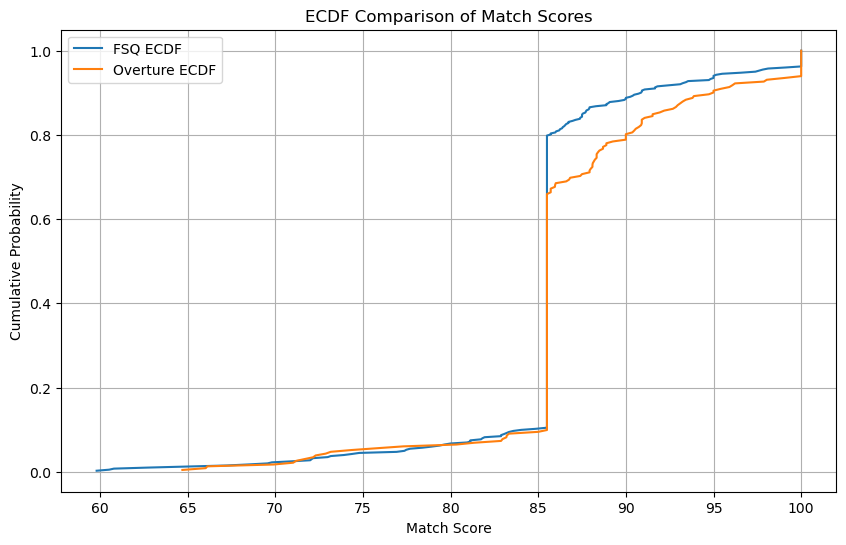

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fsq_scores = matched_fsq['match_score']
overture_scores = matched_overture['match_score']

# Sort values
fsq_sorted = np.sort(fsq_scores)
overture_sorted = np.sort(overture_scores)

# Compute ECDF values
fsq_ecdf = np.arange(1, len(fsq_sorted)+1) / len(fsq_sorted)
overture_ecdf = np.arange(1, len(overture_sorted)+1) / len(overture_sorted)

# Plot ECDF
plt.figure(figsize=(10,6))
plt.plot(fsq_sorted, fsq_ecdf, label='FSQ ECDF')
plt.plot(overture_sorted, overture_ecdf, label='Overture ECDF')

plt.xlabel("Match Score")
plt.ylabel("Cumulative Probability")
plt.title("ECDF Comparison of Match Scores")
plt.legend()
plt.grid(True)
plt.show()


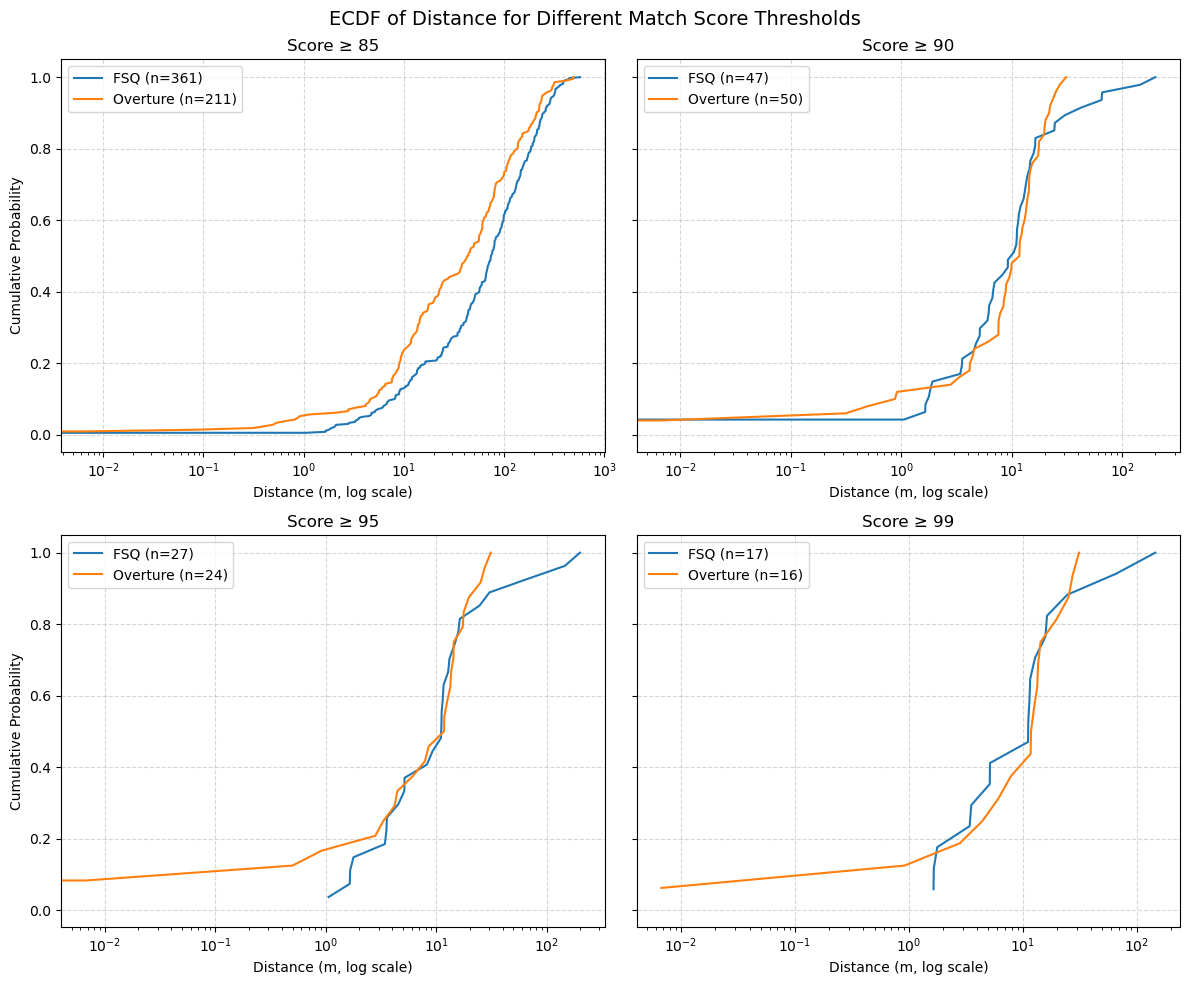

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data):
    """Compute ECDF for a 1D array."""
    data = np.sort(data)
    n = len(data)
    y = np.arange(1, n+1) / n
    return data, y

thresholds = [85, 90, 95, 99]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.ravel()

for ax, th in zip(axes, thresholds):
    fsq_sub = matched_fsq[
        (matched_fsq["match_score"] >= th) &
        (~matched_fsq["match_dist_m"].isna())
    ]
    ovt_sub = matched_overture[
        (matched_overture["match_score"] >= th) &
        (~matched_overture["match_dist_m"].isna())
    ]
    
    fsq_dist = fsq_sub["match_dist_m"].values
    ovt_dist = ovt_sub["match_dist_m"].values
    
    if len(fsq_dist) == 0 or len(ovt_dist) == 0:
        ax.text(0.5, 0.5, f"No data for threshold {th}", ha='center')
        ax.set_title(f"Score ≥ {th}")
        continue
    
    x_fsq, y_fsq = ecdf(fsq_dist)
    x_ovt, y_ovt = ecdf(ovt_dist)
    
    ax.plot(x_fsq, y_fsq, label=f"FSQ (n={len(fsq_dist)})")
    ax.plot(x_ovt, y_ovt, label=f"Overture (n={len(ovt_dist)})")
    
    ax.set_xscale("log")  
    ax.set_title(f"Score ≥ {th}")
    ax.set_xlabel("Distance (m, log scale)")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

axes[0].set_ylabel("Cumulative Probability")
axes[2].set_ylabel("Cumulative Probability")

fig.suptitle("ECDF of Distance for Different Match Score Thresholds", fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np

def completeness_by_threshold(
    matched_df: pd.DataFrame,
    google_df: pd.DataFrame,
    thresholds=(85, 90, 95, 99),
    score_col="match_score",
    matched_id_col="matched_id",
    google_id_col="id",
    dist_col=None,
    max_dist=None,
    dataset_name="FSQ"
):
    """
    Compute completeness for multiple score thresholds.

    completeness(T) = (# unique Google IDs matched with score>=T [+ distance filter])
                      / (# unique Google IDs in google_df)
    """
    n_google = google_df[google_id_col].nunique()
    rows = []

    for th in thresholds:
        sub = matched_df.copy()

        sub = sub[sub[score_col] >= th]

        if dist_col is not None and max_dist is not None:
            sub = sub[sub[dist_col] <= max_dist]

        n_covered = sub[matched_id_col].nunique()

        rows.append({
            "dataset": dataset_name,
            "threshold": th,
            "n_google_total": n_google,
            "n_google_covered": n_covered,
            "completeness": n_covered / n_google if n_google > 0 else np.nan
        })

    return pd.DataFrame(rows)


In [13]:
thresholds = [85, 90, 95, 99]

fsq_comp = completeness_by_threshold(
    matched_df=matched_fsq,
    google_df=google_placescat_100,
    thresholds=thresholds,
    score_col="match_score",
    matched_id_col="matched_id",
    google_id_col="id",
    dist_col="match_dist_m",   # 如果暂时不想加距离过滤，可以传 None
    max_dist=None,
    dataset_name="FSQ"
)

ovt_comp = completeness_by_threshold(
    matched_df=matched_overture,
    google_df=google_placescat_100,
    thresholds=thresholds,
    score_col="match_score",
    matched_id_col="matched_id",
    google_id_col="id",
    dist_col="match_dist_m",
    max_dist=None,
    dataset_name="Overture"
)

comp_all = pd.concat([fsq_comp, ovt_comp], ignore_index=True)
print(comp_all)

    dataset  threshold  n_google_total  n_google_covered  completeness
0       FSQ         85             212               113      0.533019
1       FSQ         90             212                46      0.216981
2       FSQ         95             212                27      0.127358
3       FSQ         99             212                17      0.080189
4  Overture         85             212               101      0.476415
5  Overture         90             212                48      0.226415
6  Overture         95             212                24      0.113208
7  Overture         99             212                16      0.075472


primary_cat
Food and Drink                  42
Entertainment and Recreation    34
Shopping                        28
Transportation                  27
Services                        26
Health and Wellness             11
Automotive                      10
Places of Worship                9
Finance                          6
Education                        5
Sports                           4
Business                         3
Government                       3
Culture                          2
Facilities                       1
Natural Features                 1
Name: count, dtype: int64

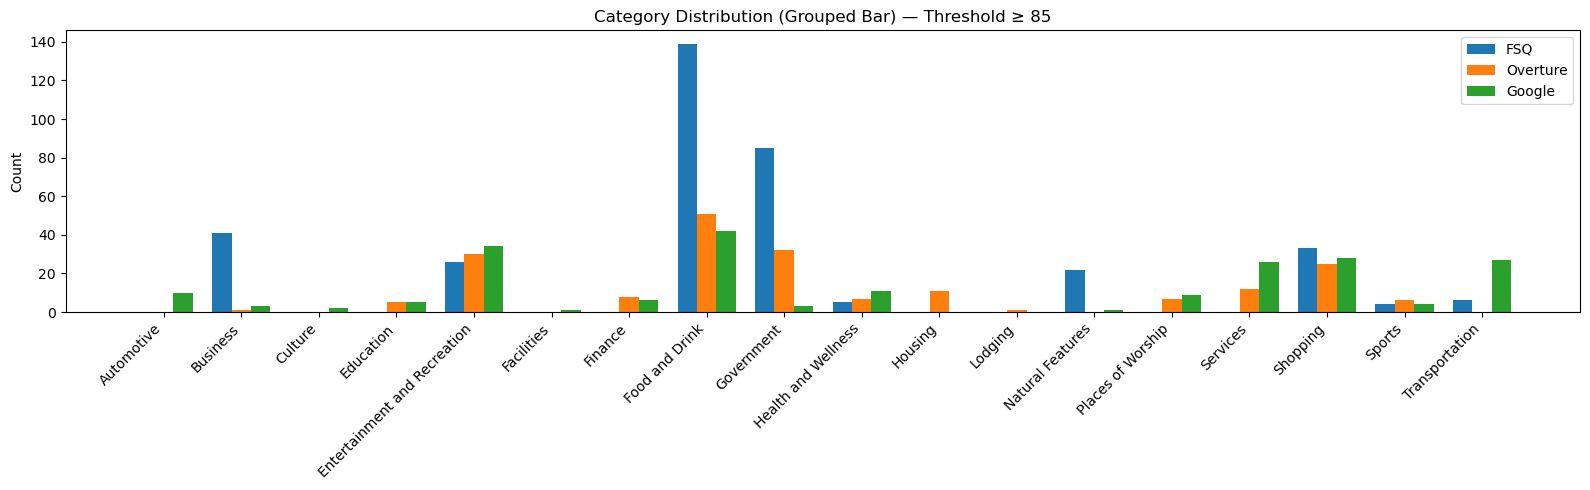

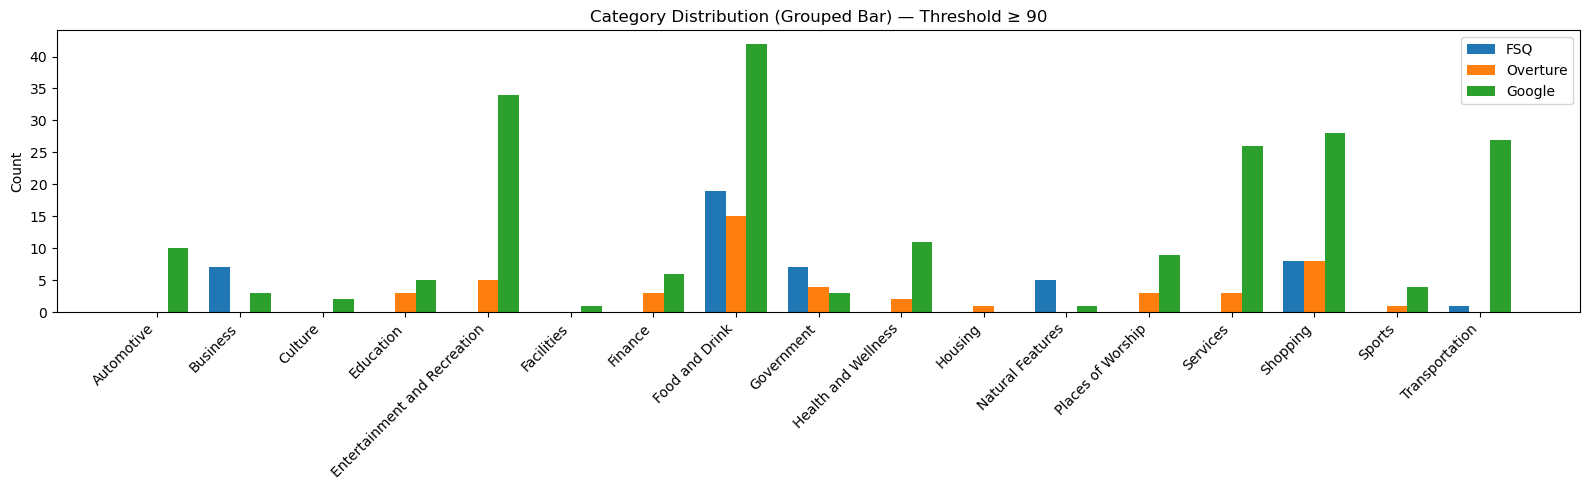

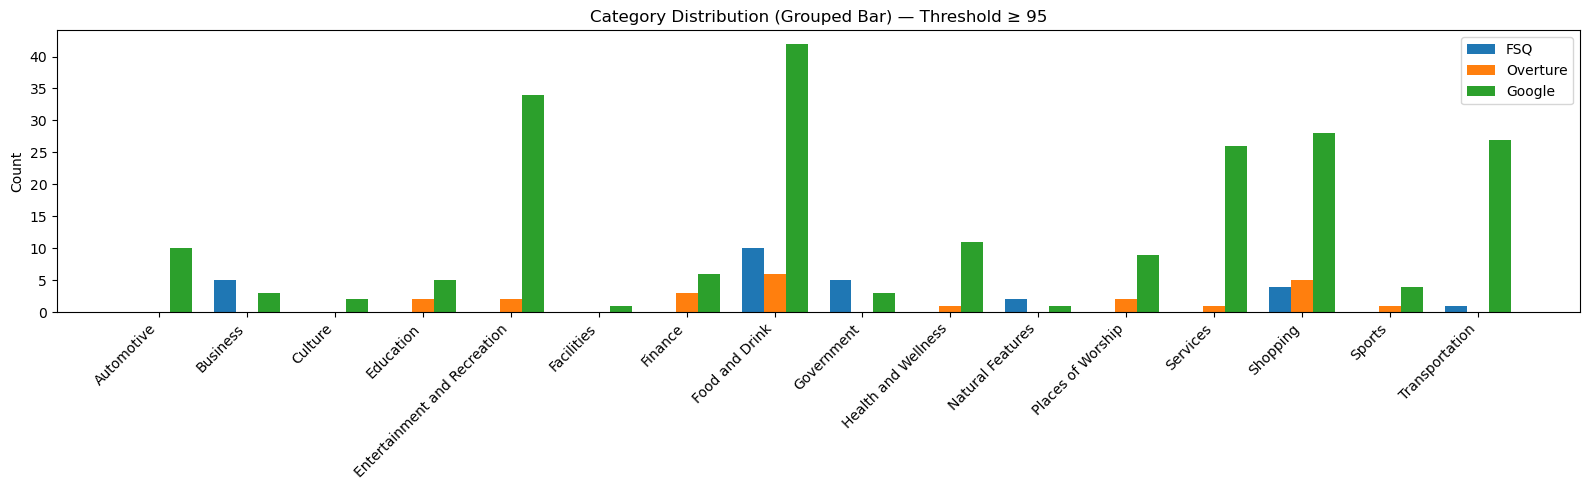

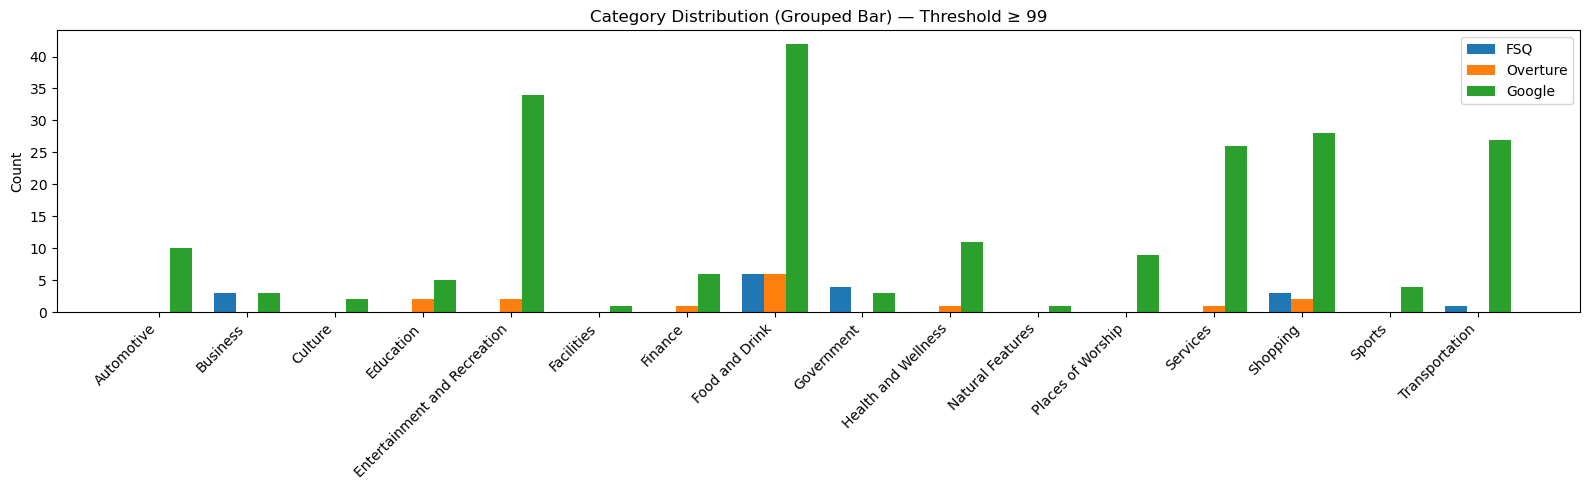

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

thresholds = [85, 90, 95, 99]

for th in thresholds:
    # 1) 过滤 FSQ & Overture
    fsq_filtered = matched_fsq[matched_fsq["match_score"] >= th]
    overture_filtered = matched_overture[matched_overture["match_score"] >= th]

    # 2) 各自统计类别数量
    fsq_counts = fsq_filtered["google_category"].value_counts()
    overture_counts = overture_filtered["google_category"].value_counts()
    google_counts = google_placescat_100["primary_cat"].value_counts()

    # 3) 统一类别并集
    all_categories = sorted(
        set(fsq_counts.index)
        | set(overture_counts.index)
        | set(google_counts.index)
    )

    # 4) 对齐
    fsq_aligned = fsq_counts.reindex(all_categories, fill_value=0)
    overture_aligned = overture_counts.reindex(all_categories, fill_value=0)
    google_aligned = google_counts.reindex(all_categories, fill_value=0)

    # 转成 numpy
    fsq_vals = fsq_aligned.values
    overture_vals = overture_aligned.values
    google_vals = google_aligned.values

    x = np.arange(len(all_categories))
    width = 0.25  # 单个柱子的宽度

    # 5) 画 grouped bar
    plt.figure(figsize=(16, 5))
    plt.title(f"Category Distribution (Grouped Bar) — Threshold ≥ {th}")

    plt.bar(x - width, fsq_vals, width, label="FSQ")
    plt.bar(x, overture_vals, width, label="Overture")
    plt.bar(x + width, google_vals, width, label="Google")

    plt.xticks(x, all_categories, rotation=45, ha="right")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [107]:
test = matched_fsq[matched_fsq['match_score']>= 90]
test1 = test[test['google_category']=='Business']
test1

,id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,bbox,geometry,addr,match_key,google_category,matched_addr,matched_id,match_score,match_dist_m,is_above_threshold
360,5d2c97f85cbbb2002382c369,KeyMe Locksmiths,34.410712,-119.856028,6545 Trigo Road,Isla Vista,CA,93117,NaN,NaN,...,"{'xmin': '-119.85602757719809', 'ymin': '34.41...",POINT (-119.85603 34.41071),"6545 trigo road, isla vista, ca 93117","6545 trigo road, isla vista, ca 93117,keyme lo...",Business,"6545 trigo rd, isla vista, ca 93117,keyme lock...",ChIJ1WKlh_k_6YARSobKdK1sREU,98.113208,1.058774,True
301,79ac42c18058467eb0185c60,Nespor's University Auto House,34.412640,-119.855105,924 Embarcadero Del Norte,Goleta,CA,93117,NaN,NaN,...,"{'xmin': '-119.855105', 'ymin': '34.41264', 'x...",POINT (-119.85510 34.41264),"924 embarcadero del norte, goleta, ca 93117","924 embarcadero del norte, goleta, ca 93117,ne...",Business,"924 embarcadero del norte, goleta, ca 93117,ne...",ChIJUTwv-mg_6YARPvCj9QNwcdc,100.000000,1.647421,True
234,bf72c5e08ecd4ce93dbcb1ee,CoinFlip Bitcoin ATM,34.412979,-119.855750,6547 Pardall Rd Unit B,Isla Vista,CA,93117,NaN,NaN,...,"{'xmin': '-119.85575014944426', 'ymin': '34.41...",POINT (-119.85575 34.41298),"6547 pardall rd unit b, isla vista, ca 93117","6547 pardall rd unit b, isla vista, ca 93117,c...",Business,"6547 pardall rd unit b, isla vista, ca 93117,c...",ChIJ60wQq3E_6YARpUNk8be-GCo,90.000000,4.755127,True
228,1c3c6eb86f0d4c1ee24453f5,Richies Barber Shop,34.412966,-119.856031,6549 Pardall Rd,Goleta,CA,93117,NaN,NaN,...,"{'xmin': '-119.856031440053', 'ymin': '34.4129...",POINT (-119.85603 34.41297),"6549 pardall rd, goleta, ca 93117","6549 pardall rd, goleta, ca 93117,richies barb...",Business,"6549 pardall rd, goleta, ca 93117,richies barb...",ChIJx9vBRYI_6YAR0Uk3cAUIKAM,100.000000,5.160501,True
123,90a8cab4e2d64595e40d035f,Eckert Investment,34.413667,-119.858942,851 Camino Pescadero,Goleta,CA,93117,NaN,NaN,...,"{'xmin': '-119.85894234276964', 'ymin': '34.41...",POINT (-119.85894 34.41367),"851 camino pescadero, goleta, ca 93117","851 camino pescadero, goleta, ca 93117,eckert ...",Business,"851 camino pescadero # b, goleta, ca 93117,eck...",ChIJS96qUl0_6YARH9wVcboreI8,96.551724,9.232028,True
115,73741437512c4b1c3891b4e8,Eagle Carpet Cleaning,34.415446,-119.861114,6662 Picasso Rd Apt G,Goleta,CA,93117,NaN,NaN,...,"{'xmin': '-119.86111407452584', 'ymin': '34.41...",POINT (-119.86111 34.41545),"6662 picasso rd apt g, goleta, ca 93117","6662 picasso rd apt g, goleta, ca 93117,eagle ...",Business,"6662 picasso rd, goleta, ca 93117,eagle carpet...",ChIJUWr0AF0_6YARBXvyoh_i6PY,94.827586,9.233546,True
235,50c7693fe4b0d6775258a4c8,Chase Bank,34.412969,-119.855723,901 Embarcadero del Norte,Goleta,CA,93117,NaN,NaN,...,"{'xmin': '-119.855723', 'ymin': '34.412969', '...",POINT (-119.85572 34.41297),"901 embarcadero del norte, goleta, ca 93117","901 embarcadero del norte, goleta, ca 93117,ch...",Business,"901 embarcadero del norte, goleta, ca 93117,ch...",ChIJl8YyWWg_6YARyaZiNc0z3No,100.000000,12.816354,True


In [111]:
matched_overture[matched_overture['match_score'] >= 86]

,id,names,categories,confidence,addresses,operating_status,version,sources,bbox,WKB,...,addr,name,match_key,primary,google_category,matched_addr,matched_id,match_score,match_dist_m,is_above_threshold
18,44726df6-5038-4fbe-8a46-4f0cf6e7e586,{'primary': 'Wells Fargo ATM'},"{'primary': 'bank_credit_union', 'alternate': ...",0.947100,"[ { ""freeform"": ""6530A Pardall Ave"", ""locality...",open,1,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...","{'xmin': -119.85486602783203, 'xmax': -119.854...",0000000001C05DF6B5ECB67720404134E5A434274F,...,"6530a pardall ave, isla vista, ca 93117",Wells Fargo ATM,"6530a pardall ave, isla vista, ca 93117,wells ...",bank_credit_union,Finance,"6530a pardall rd, isla vista, ca 93117,wells f...",ChIJ29N-8mg_6YARZJItce2O694,95.412844,0.000000,True
8,f608a794-6c34-4939-b7e4-11fc638d9604,{'primary': 'Institute of Religion - The Churc...,"{'primary': 'religious_school', 'alternate': [...",0.770000,"[ { ""freeform"": ""6524 Cordoba Road"", ""locality...",open,3,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...","{'xmin': -119.8550033569336, 'xmax': -119.8549...",0000000001C05DF6B856F4029C404134FB1473548B,...,"6524 cordoba road, goleta, ca 93117",Institute of Religion - The Church of Jesus Ch...,"6524 cordoba road, goleta, ca 93117,institute ...",religious_school,Education,"6524 cordoba rd, goleta, ca 93117,institute of...",ChIJAzZdjmg_6YARA8VbcyBzd70,99.056604,0.006747,True
56,7c7ac317-ee1a-425b-ad53-faa8b1dea95f,{'primary': 'Chop Chinese Food'},"{'primary': 'restaurant', 'alternate': ['fast_...",0.982836,"[ { ""freeform"": ""966 Embarcadero del Mar"", ""lo...",open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85679626464844, 'xmax': -119.856...",0000000001C05DF6D5B8993922404134B37BC2EEFD,...,"966 embarcadero del mar, goleta, ca 93117",Chop Chinese Food,"966 embarcadero del mar, goleta, ca 93117,chop...",restaurant,Food and Drink,"966 embarcadero del mar unit c, isla vista, ca...",ChIJIyGWZbE_6YARDHPhT04IIkA,86.821705,0.085873,False
186,23638328-af40-43ca-b45c-788d0aa89996,{'primary': 'Santa Barbara Hillel'},"{'primary': 'community_services_non_profits', ...",0.990099,"[ { ""freeform"": ""781 Embarcadero del Mar"", ""lo...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85739135742188, 'xmax': -119.857...",0000000001C05DF6DF72565EB14041352C88F506A8,...,"781 embarcadero del mar, goleta, ca 93117",Santa Barbara Hillel,"781 embarcadero del mar, goleta, ca 93117,sant...",community_services_non_profits,Government,"781 embarcadero del mar, isla vista, ca 93117,...",ChIJwbvklGc_6YARpTaRr4sTqpg,92.187500,0.315408,True
14,3ffaedfb-286a-4ff8-b75e-00d78f163d3f,{'primary': 'Subway'},"{'primary': 'sandwich_shop', 'alternate': ['re...",0.335048,"[ { ""freeform"": ""888 Embarcadero del Norte"", ""...",open,3,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...","{'xmin': -119.85514831542969, 'xmax': -119.855...",0000000001C05DF6BA874FEAFA404134E7D2E29083,...,"888 embarcadero del norte, goleta, ca 93117",Subway,"888 embarcadero del norte, goleta, ca 93117,su...",sandwich_shop,Shopping,"888 embarcadero del norte, goleta, ca 93117,wi...",ChIJtTs0LO0_6YARQfmdgadwNQA,88.235294,0.401658,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,71d33d3f-5513-4802-8929-4fb7ab2ab03a,{'primary': 'Farmacy Isla Vista'},"{'primary': 'cannabis_dispensary', 'alternate'...",0.947100,"[ { ""freeform"": ""6555 Pardall Rd"", ""locality"":...",open,5,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...","{'xmin': -119.85659790039062, 'xmax': -119.856...",0000000001C05DF6D27A8BB759404134E1C2FE16F2,...,"6555 pardall rd, goleta, ca 93117",Farmacy Isla Vista,"6555 pardall rd, goleta, ca 93117,farmacy isla...",cannabis_dispensary,Shopping,"6555 pardall rd, goleta, ca 93117,farmacy isla...",ChIJUXTrHy4_6YARKcw8x6ds2Po,100.000000,31.170894,True
95,c9b3c93e-9de6-41e8-9547-e3178daa5a1b,{'primary': 'Camino 

In [15]:
import geopandas as gpd
import folium

for gdf in [matched_overture, matched_fsq, google_placescat_100]:
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        gdf.to_crs(epsg=4326, inplace=True)
m = matched_overture[matched_overture['match_score'] >= 86].explore(
    name="Overture",
    popup=["id", "name", "addr","match_key","google_category"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "red"},
    legend=True,
    legend_kwds={"label": "Overture Places", "color": "red"}
)

matched_fsq[matched_fsq['match_score'] >= 86].explore(
    m=m,
    name="Foursquare",
    popup=["id", "name", "addr","match_key","google_category"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "blue"},
    legend=True,
    legend_kwds={"label": "Foursquare Places", "color": "blue"}
)

google_placescat_100.explore(
    m=m,
    name="Google Places (cat 100)",
    popup=["id", "name", "addr","match_key","category","primary_cat"],
    tooltip=False, 
    marker_type="circle_marker",
    marker_kwds={"radius": 6, "color": "green"},
    legend=True,
    legend_kwds={"label": "Google Places", "color": "green"}
)

folium.LayerControl(collapsed=False).add_to(m)
m

# Query from SafeGraph

# MSA region

In [3]:
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
us_msa

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry
2,3,10180,"Abilene, TX",Metropolitan Statistical Area,7105668291,36756436,"POLYGON ((-99.11755 32.25045, -99.11756 32.250..."
5,6,10380,"Aguadilla, PR",Metropolitan Statistical Area,769374621,354393993,"POLYGON ((-67.12305 18.24282, -67.12308 18.242..."
6,7,10420,"Akron, OH",Metropolitan Statistical Area,2331510400,62132699,"POLYGON ((-81.42037 40.90651, -81.42042 40.906..."
9,10,10500,"Albany, GA",Metropolitan Statistical Area,4120596069,46238444,"POLYGON ((-83.71414 31.31837, -83.71439 31.318..."
10,11,10540,"Albany, OR",Metropolitan Statistical Area,5929809282,50118766,"POLYGON ((-122.89761 44.74495, -122.89749 44.7..."
...,...,...,...,...,...,...,...
927,928,49420,"Yakima, WA",Metropolitan Statistical Area,11122734369,41188782,"POLYGON ((-120.33109 46.04149, -120.34027 46.0..."
929,930,49620,"York-Hanover, PA",Metropolitan Statistical Area,2342295974,16503210,"POLYGON ((-76.46114 39.72131, -76.46188 39.721..."
930,931,49660,"Youngstown-Warren, OH",Metropolitan Statistical Area,2665268781,83270347,"POLYGON ((-81.00244 41.11912, -81.00243 41.119..."
931,932,49700,"Yuba City, CA",Metropolitan Statistical Area,3197863370,45895634,"POLYGON ((-121.48441 38.73460, -121.48459 38.7..."


In [33]:
us_msa = us_msa.to_crs(epsg=3857)
us_msa_union = us_msa.geometry.unary_union
us_msa_union_km2 = us_msa_union.area / 1e6  
us_msa_union_km2

4873805.790968443

In [34]:
pop_cbsa = gpd.read_file("/Users/houpuli/Downloads/ACSDT5YSPT2021.B01003_2025-12-16T161141.zip", header=0)
pop_cbsa = pop_cbsa.iloc[1:]
pop_cbsa["CBSACODE"] = pop_cbsa["GEO_ID"].str[-5:]
pop_cbsa = pop_cbsa.rename(columns={"B01003_001E": "tot_pop"})
pop_cbsa = pop_cbsa[['CBSACODE','tot_pop']]
pop_cbsa = pop_cbsa.astype({'tot_pop': 'int64'})
pop_cbsa

,CBSACODE,tot_pop
1,10100,42476
2,10140,74737
3,10180,175241
4,10220,38102
5,10300,99346
...,...,...
935,49660,542459
936,49700,179484
937,49740,202944
938,49780,86346


In [35]:
us_msa = us_msa.merge(pop_cbsa, on='CBSACODE', how='left')
us_msa = us_msa.dropna(subset=['tot_pop'])
us_msa = us_msa.sort_values("tot_pop").reset_index(drop=True)

msa_small_5 = us_msa.iloc[:5]
msa_small_10 = us_msa.iloc[:10]
msa_small_30 = us_msa.iloc[:30]
msa_large_5 = us_msa.iloc[-5:]
msa_large_10 = us_msa.iloc[-10:]
msa_large_30 = us_msa.iloc[-30:]

n = len(us_msa)
mid_start_30 = n // 2 - 15
mid_end_30   = n // 2 + 15
msa_middle_30 = us_msa.iloc[mid_start_30:mid_end_30]

mid_start_10 = n // 2 - 5
mid_end_10   = n // 2 + 5
msa_middle_10 = us_msa.iloc[mid_start_10:mid_end_10]

mid_start_5 = n // 2 - 2
mid_end_5   = n // 2 + 3
msa_middle_5 = us_msa.iloc[mid_start_5:mid_end_5]

msa_filter_30 = pd.concat([msa_small_30, msa_middle_30, msa_large_30], ignore_index=True)
msa_filter_30 = msa_filter_30.reset_index(drop=True)

msa_filter_10 = pd.concat([msa_small_10, msa_middle_10, msa_large_10], ignore_index=True)
msa_filter_10 = msa_filter_10.reset_index(drop=True)

msa_filter_5 = pd.concat([msa_small_5, msa_middle_5, msa_large_5], ignore_index=True)
msa_filter_5 = msa_filter_5.reset_index(drop=True)

In [36]:
msa_filter_union_30 = msa_filter_30.geometry.unary_union
msa_filter_union_30_km2 = msa_filter_union_30.area / 1e6  
msa_filter_union_30_km2

1490706.6565003593

In [37]:
msa_filter_union_10 = msa_filter_10.geometry.unary_union
msa_filter_union_10_km2 = msa_filter_union_10.area / 1e6  
msa_filter_union_10_km2

510887.1811204743

In [41]:
msa_filter_union_5 = msa_filter_5.geometry.unary_union
msa_filter_union_5_km2 = msa_filter_union_5.area / 1e6  
msa_filter_union_5_km2

251650.34412854628

In [42]:
msa_filter_5

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry,tot_pop
0,247,20580,"Eagle Pass, TX",Metropolitan Statistical Area,3313819983,31871181,"POLYGON ((-11206239.954 3386380.667, -11206218...",57769.0
1,146,16180,"Carson City, NV",Metropolitan Statistical Area,374341371,32594082,"POLYGON ((-13358818.683 4745421.371, -13358482...",57957.0
2,885,47460,"Walla Walla, WA",Metropolitan Statistical Area,3289370357,74932288,"POLYGON ((-13180654.160 5780474.045, -13180792...",62168.0
3,266,21420,"Enid, OK",Metropolitan Statistical Area,2741521326,4075930,"POLYGON ((-10920934.315 4364647.514, -10920932...",62628.0
4,480,30300,"Lewiston, ID-WA",Metropolitan Statistical Area,3844567744,32544611,"POLYGON ((-12992950.553 5867919.979, -12992947...",64105.0
5,37,11540,"Appleton, WI",Metropolitan Statistical Area,2475529646,222422502,"POLYGON ((-9800974.967 5489228.280, -9800975.6...",241748.0
6,303,22900,"Fort Smith, AR-OK",Metropolitan Statistical Area,4662049165,166503067,"POLYGON ((-10489905.568 4173467.071, -10489917...",245235.0
7,89,13780,"Binghamton, NY",Metropolitan Statistical Area,3171226605,36122815,"POLYGON ((-8431586.708 5160688.163, -8432541.2...",247158.0
8,280,22020,"Fargo, ND-MN",Metropolitan Statistical Area,7278152640,26752493,"POLYGON ((-10719931.917 5882020.348, -10719946...",247967.0
9,928,49420,"Yakima, WA",Metropolitan Statistical Area,11122734369,41188782,"POLYGON ((-13395195.244 5787000.956, -13396217...",255151.0


In [8]:
msa_filter_30.to_csv("/Users/houpuli/Downloads/msa_filter_30.csv")

In [9]:
pop_places = gpd.read_file("/Users/houpuli/Downloads/ACSDT5YSPT2021.B01003_2025-12-16T173152.zip")
pop_places = pop_places.iloc[1:]
pop_places["PLACECODE"] = pop_places["GEO_ID"].str[-7:]
pop_places = pop_places.rename(columns={"B01003_001E": "tot_pop"})
pop_places = pop_places[['PLACECODE','tot_pop']]
pop_places = pop_places.astype({'tot_pop': 'int64'})
pop_places

,PLACECODE,tot_pop
1,0100124,2231
2,0100460,4381
3,0100484,697
4,0100820,33133
5,0100988,22268
...,...,...
24124,7286831,2966
24125,7287863,6466
24126,7288035,15404
24127,7288121,927


In [10]:
us_places = gpd.read_file("/Users/houpuli/Downloads/cb_2024_us_place_500k.zip")
us_places = us_places.rename(columns={'GEOID':'PLACECODE'})
us_places = us_places[['PLACECODE','NAMELSAD','STATE_NAME','geometry']]
us_places = us_places.merge(pop_places, on='PLACECODE', how='left')
us_places = us_places.dropna(subset=['tot_pop'])
us_places = us_places.sort_values("tot_pop").reset_index(drop=True)
us_places

,PLACECODE,NAMELSAD,STATE_NAME,geometry,tot_pop
0,2756698,St. Anthony city,Minnesota,"POLYGON ((-94.62005 45.69417, -94.60968 45.694...",71.0
1,2769880,Whipholt CDP,Minnesota,"POLYGON ((-94.40579 47.05780, -94.40489 47.062...",73.0
2,1950205,Masonville city,Iowa,"POLYGON ((-91.59811 42.48381, -91.58831 42.483...",74.0
3,1984835,Westwood city,Iowa,"POLYGON ((-91.63226 40.96399, -91.62977 40.966...",74.0
4,4017550,Council Hill town,Oklahoma,"POLYGON ((-95.65992 35.55906, -95.64661 35.558...",75.0
...,...,...,...,...,...
24101,4260000,Philadelphia city,Pennsylvania,"POLYGON ((-75.28027 39.97496, -75.27648 39.976...",1596865.0
24102,4835000,Houston city,Texas,"MULTIPOLYGON (((-95.17342 29.80781, -95.16994 ...",2293288.0
24103,1714000,Chicago city,Illinois,"POLYGON ((-87.94010 42.00079, -87.93530 42.000...",2742119.0
24104,0644000,Los Angeles city,California,"POLYGON ((-118.66816 34.18414, -118.66814 34.1...",3902440.0


In [83]:
places_small_10 = us_places.iloc[:10]
places_small_30 = us_places.iloc[:30]
places_large_10 = us_places.iloc[-10:]
places_large_30 = us_places.iloc[-30:]

n = len(us_places)
mid_start_30 = n // 2 - 15
mid_end_30   = n // 2 + 15
places_middle_30 = us_places.iloc[mid_start_30:mid_end_30]

mid_start_10 = n // 2 - 5
mid_end_10   = n // 2 + 5
places_middle_10 = us_places.iloc[mid_start_10:mid_end_10]

places_filter_30 = pd.concat([places_small_30, places_middle_30, places_large_30], ignore_index=True)
places_filter_30 = places_filter_30.reset_index(drop=True)

places_filter_10 = pd.concat([places_small_10, places_middle_10, places_large_10], ignore_index=True)
places_filter_10 = places_filter_10.reset_index(drop=True)

In [85]:
places_filter_30.to_csv("/Users/houpuli/Downloads/places_filter_30.csv")

# Demo Test in MSA Newyork

In [3]:
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
us_msa

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry
2,3,10180,"Abilene, TX",Metropolitan Statistical Area,7105668291,36756436,"POLYGON ((-99.11755 32.25045, -99.11756 32.250..."
5,6,10380,"Aguadilla, PR",Metropolitan Statistical Area,769374621,354393993,"POLYGON ((-67.12305 18.24282, -67.12308 18.242..."
6,7,10420,"Akron, OH",Metropolitan Statistical Area,2331510400,62132699,"POLYGON ((-81.42037 40.90651, -81.42042 40.906..."
9,10,10500,"Albany, GA",Metropolitan Statistical Area,4120596069,46238444,"POLYGON ((-83.71414 31.31837, -83.71439 31.318..."
10,11,10540,"Albany, OR",Metropolitan Statistical Area,5929809282,50118766,"POLYGON ((-122.89761 44.74495, -122.89749 44.7..."
...,...,...,...,...,...,...,...
927,928,49420,"Yakima, WA",Metropolitan Statistical Area,11122734369,41188782,"POLYGON ((-120.33109 46.04149, -120.34027 46.0..."
929,930,49620,"York-Hanover, PA",Metropolitan Statistical Area,2342295974,16503210,"POLYGON ((-76.46114 39.72131, -76.46188 39.721..."
930,931,49660,"Youngstown-Warren, OH",Metropolitan Statistical Area,2665268781,83270347,"POLYGON ((-81.00244 41.11912, -81.00243 41.119..."
931,932,49700,"Yuba City, CA",Metropolitan Statistical Area,3197863370,45895634,"POLYGON ((-121.48441 38.73460, -121.48459 38.7..."


In [4]:
msa_ny = us_msa[us_msa['CBSACODE']=='35620']
msa_ny

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry
607,608,35620,"New York-Newark-Jersey City, NY-NJ",Metropolitan Statistical Area,15901418738,6489996005,"POLYGON ((-74.41689 39.82269, -74.41713 39.823..."


In [5]:
msa_ny.bounds

,minx,miny,maxx,maxy
607,-75.195498,39.475206,-71.777492,41.527202


In [7]:
ny_fsq = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_fsq.geojson')
ny_fsq

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,facebook_id,instagram,twitter,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,geometry
0,4a6e1308f964a520d8d31fe3,Taan Thai Cuisine,40.746072,-73.984882,17 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d149941735],[Dining and Drinking > Restaurant > Asian Rest...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8IUJc9mkBEX39LQHHp,"{'xmin': '-73.98488249559014', 'ymin': '40.746...",POINT (-73.98488 40.74607)
1,4fc8bb8de4b0936e6f5fb166,Maxifier,40.745854,-73.984607,130 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8DzxzYSEBEX3ghkfAx,"{'xmin': '-73.98460748497848', 'ymin': '40.745...",POINT (-73.98461 40.74585)
2,4ba7b867f964a520e8ac39e3,Sunshine Sachs,40.745991,-73.984504,136 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,"[4bf58dd8d48988d124941735, 4bf58dd8d48988d1309...","[Business and Professional Services > Office, ...",https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8CHyD2ZUBEX3yhssiK,"{'xmin': '-73.98450449198715', 'ymin': '40.745...",POINT (-73.98450 40.74599)
3,529ba9b411d2c184dc1c79c2,Bella Minds HQ,40.746021,-73.984396,"136 Madison, 5th Floor Suite 548",New York,NY,10016,NaN,NaN,...,NaN,NaN,bellaminds,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602)
4,530b7c6d11d200e77d5f16c3,The Bakery Design Lab at Smartling,40.746021,-73.984396,136 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080296,13fc496dea484e814cf87de8,Lim's Graphic Co.,40.745899,-73.984915,20 E 31st St,New York,NY,10016,NaN,NaN,...,1.566488e+14,NaN,NaN,[63be6904847c3692a84b9b90],[Business and Professional Services > Technolo...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8I2OTJakBEX3mgcgmy,"{'xmin': '-73.98491499273737', 'ymin': '40.745...",POINT (-73.98491 40.74590)
2080297,51d4e35c498e004fa7874cd6,Korean Restaurant Bar,40.745983,-73.985278,NaN,New York,NY,NaN,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d116941735],[Dining and Drinking > Bar],https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8Oy3Td+EBEX3xe9i+d,"{'xmin': '-73.985278', 'ymin': '40.745983', 'x...",POINT (-73.98528 40.74598)
2080298,4f3282f819836c91c7def820,Blimpie,40.746005,-73.985006,17 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d16e941735],[Dining and Drinking > Restaurant > Fast Food ...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8KWJWXrEBEX30U42ls,"{'xmin': '-73.9850064717163', 'ymin': '40.7460...",POINT (-73.98501 40.74600)
2080299,4dfa9a851f6eeef806a85783,Manhattan Sikh Association,40.746005,-73.985006,18 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d171941735],[Business and Professional Services > Event Sp...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8KWJWXrEBEX30U42ls,"{'xmin': '-73.9850064717163', 'ymin': '40.7460...",POINT (-73.98501 40.74600)


In [8]:
ny_ove = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_ove.geojson')
ny_ove

,id,names,confidence,cat_main,cat_alt,address,operating_status,version,sources,geometry
0,06e0f3c1-b654-425f-9588-a1bd8943534a,EasyGenie,0.570194,genealogists,NaN,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
1,0d8bbca1-0a0e-4b7a-b3d7-2fe74be2ecfb,Bible Nook,0.570194,religious_organization,bookstore,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
2,e529a474-ed71-4462-a5da-0d30e5494ad4,Hitched Hiking marriage ministry,0.570194,community_services_non_profits,life_coach,,open,2,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
3,cea6de5f-6543-4690-8f19-786d8e95a8fb,TICA Northeast Region,0.570194,community_services_non_profits,public_and_government_association,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
4,afb616d6-e780-4539-9009-d7880a767c0f,Indigo Studio,0.570194,cosmetic_and_beauty_supplies,social_media_agency,"Roselle Park Environmental Commission, 110 E W...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.66357 39.92238)
...,...,...,...,...,...,...,...,...,...,...
1083610,102b252e-5737-4b6d-91db-08849ece5da3,Sure Design,0.950063,printing_services,professional_services,5027 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12314 40.18954)
1083611,09351d28-ba24-4a4c-9284-f0d912ab112a,ITAK Heating & Cooling,0.950063,hvac_services,"contractor, plumbing",5027 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12321 40.18954)
1083612,414bafb2-51a1-4b9d-84d8-6320f26bd42b,J. McGinley Company,0.950063,industrial_equipment,"iron_and_steel_industry, automotive",5023 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12221 40.18989)
1083613,2c9b4e95-a646-4147-b44b-9aebf0568930,ITAK Heating & Cooling,0.770000,hvac_services,NaN,"Lower Level, 5027 Industrial Rd Unit 6",open,4,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...",POINT (-74.12312 40.18928)


In [ ]:
msa_google = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/msa_google_place.geojson')
msa_google

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry
607,608,35620,"New York-Newark-Jersey City, NY-NJ",Metropolitan Statistical Area,15901418738,6489996005,"POLYGON ((-74.41689 39.82269, -74.41713 39.823..."


In [108]:
address_points = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/AddressPoint_20251227.csv')
address_points["address"] = (address_points["House Number"].astype(str) + " " + address_points["Full Street Name"])

def clean_id(s):
    s = s.astype(str).str.strip()
    s = s.str.replace(",", "", regex=False)   
    s = s.str.replace(r"\.0$", "", regex=True) 
    s = s.replace({"nan": pd.NA, "None": pd.NA})
    return s

address_points["primaryaddresspointid"] = clean_id(address_points["Address Point ID"])

In [109]:
nyc_ct_1 = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/CommonPlace_20251227.geojson')
nyc_ct_1 = nyc_ct_1.rename(columns={':id':'id',':version':'version',':created_at':'created_at',':updated_at':'updated_at'})
facility_type_lookup = {
    "1": "Residential",
    "2": "Education Facility",
    "3": "Cultural Facility",
    "4": "Recreational Facility",
    "5": "Social Services",
    "6": "Transportation Facility",
    "7": "Commercial",
    "8": "Government Facility (non public safety)",
    "9": "Religious Institution",
    "10": "Health Services",
    "11": "Public Safety",
    "12": "Water",
    "13": "Miscellaneous",
}
borough_lookup = {
    "1": "Manhattan",
    "2": "Bronx",
    "3": "Brooklyn",
    "4": "Queens",
    "5": "Staten Island",
    "6": "Nassau County",
    "7": "Westchester",
    "8": "New Jersey",
}

nyc_ct_1["borough"] = nyc_ct_1["boroughcode"].map(borough_lookup)
nyc_ct_1["facility_type"] = nyc_ct_1["facility_type"].map(facility_type_lookup)

nyc_ct_1 = nyc_ct_1.merge(address_points[['address','primaryaddresspointid']], on='primaryaddresspointid', how='left')
nyc_ct_1 = nyc_ct_1[['id','version','updated_at','borough','placeid','objectid','source','address','facility_type','feature_name','geometry']]

In [110]:
nyc_ct_1.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/nyc_commonplace.geojson', driver="GeoJSON") 

In [ ]:
business = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/Business_SBS_Certified_Business_List_20251227.csv')
business = business.rename(columns={'Vendor_Formal_Name':'name','Address_Line_1':'address'})
business = gpd.GeoDataFrame(
    business,
    geometry=gpd.points_from_xy(business.Longitude, business.Latitude),
    crs="EPSG:4326"
)
business = business[['name','Certification_Renewal_Date','address','NAICS_Sector','NAICS_Subsector','geometry']]
business['category'] = 'business_sbs'

In [137]:
business.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/business_sbs.geojson', driver="GeoJSON") 

In [132]:
areas_of_interest = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/Areas_of_Interest_Centroids_20251227.geojson')
areas_of_interest = areas_of_interest.drop(columns=['id'])
areas_of_interest = areas_of_interest.rename(columns={':id':'id',':version':'version',':created_at':'created_at',':updated_at':'updated_at'})
areas_of_interest = areas_of_interest[['id','version','created_at','updated_at','name','geometry']]
areas_of_interest['category'] = 'Parks_Cementeries'

In [133]:
areas_of_interest.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/areas_of_interest.geojson', driver="GeoJSON")

In [173]:
nyc_colp= gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/City_Owned_and_Leased_Property_(COLP)_20251227.geojson')
nyc_colp = nyc_colp.rename(columns={':id':'id',':version':'version',':created_at':'created_at',':updated_at':'updated_at','expanded_category_code':'cat_alt'})
nyc_colp = nyc_colp[['version','created_at','updated_at','address','cat_alt','geometry']]

lookup = {
    "1": "Office use",
    "2": "Educational use",
    "3": "Cultural & recreational use",
    "4": "Public safety & criminal justice use",
    "5": "Health & social service use",
    "6": "Leased out to a private tenant",
    "7": "Maintenance, storage & infrastructure",
    "8": "Property with no use",
    "9": "Property with a residential used",
}

nyc_colp["cat_alt"] = nyc_colp["cat_alt"].map(lookup)
nyc_colp['category'] = 'COLP'
nyc_colp

,version,created_at,updated_at,address,cat_alt,geometry,category
0,rv-r5cf-e6kp-48j4,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,CONEY ISLAND CREEK,Cultural & recreational use,POINT (-73.98815 40.57969),COLP
1,rv-6py5~kqja~zqrq,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,175 STREET,Property with no use,POINT (-73.77314 40.66522),COLP
2,rv-i49f_vakw.ncea,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,NaN,Cultural & recreational use,POINT (-73.77789 40.69418),COLP
3,rv-vc6w.uqj4.avu2,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,NaN,Property with no use,POINT (-74.13723 40.59749),COLP
4,rv-sp6k.37fh~kwz2,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,12 AVENUE,Property with no use,POINT (-73.91399 40.90495),COLP
...,...,...,...,...,...,...,...
17185,rv-etww-e9c9-79c3,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,NaN,Property with no use,POINT (-73.93240 40.82472),COLP
17186,rv-9nzf-bw3c.m2es,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,NaN,Cultural & recreational use,POINT (-73.93123 40.82867),COLP
17187,rv-6wvf_s7pp~uu8i,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,99-78 LOCKWOOD COURT,Cultural & recreational use,POINT (-73.82891 40.65043),COLP
17188,rv-tvb4-k797.qs2t,2025-04-21 20:55:57.434000+00:00,2025-04-21 20:56:08.122000+00:00,2660 FRED DOUGLASS BOULEVARD,Property with a residential used,POINT (-73.94272 40.82024),COLP


In [174]:
nyc_colp.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/COLP.geojson', driver="GeoJSON")

In [175]:
DCLA_culture = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/DCLA_Cultural_Organizations_20251227.csv')
DCLA_culture["Longitude"] = pd.to_numeric(DCLA_culture["Longitude"], errors="coerce")
DCLA_culture["Latitude"] = pd.to_numeric(DCLA_culture["Latitude"], errors="coerce")
DCLA_culture.dropna(subset=['Longitude','Latitude'], inplace=True)
DCLA_culture = gpd.GeoDataFrame(DCLA_culture, geometry=gpd.points_from_xy(DCLA_culture.Longitude, DCLA_culture.Latitude), crs="EPSG:4326").reset_index(drop=True)   
DCLA_culture = DCLA_culture.rename(columns={'Organization Name':'name','Address':'address','Discipline':'cat_alt'})
DCLA_culture['category'] = 'culture'
DCLA_culture = DCLA_culture[['name','address','category','cat_alt','geometry']]
DCLA_culture

,name,address,category,cat_alt,geometry
0,122 Community Center Inc.,150 First Avenue,culture,,POINT (-73.98479 40.72826)
1,"13 Playwrights, Inc.","195 Willoughby Avenue, #402",culture,Theater,POINT (-73.96418 40.69205)
2,18 Mai Committee,"832 Franklin Avenue, PMB337",culture,"Multi-Discipline, Performing",POINT (-73.95842 40.66946)
3,20/20 Vision for Schools,8225 5th Avenue #323,culture,Visual Arts,POINT (-74.02484 40.62408)
4,24 Hour Company,151 Bank Street,culture,Theater,POINT (-74.00905 40.73611)
...,...,...,...,...,...
1859,"openhousenewyork, Inc.","1133 Broadway, Suite 802",culture,Architecture/Design,POINT (-73.98907 40.74352)
1860,"stageFARM, Inc.",302A West 12th Street,culture,Theater,POINT (-74.00456 40.73754)
1861,"terraNOVA Theatre Collective, Inc.","401 West 24th Street, Apt. 8",culture,"Multi-Discipline, Performing",POINT (-74.00127 40.74733)
1862,"thingNY, Inc.",2138 Crescent Street,culture,Music,POINT (-73.91322 40.77979)


In [ ]:
DCLA_culture.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/DCLA_culture.geojson', driver="GeoJSON")

In [183]:
dohmh_res = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/DOHMH_New_York_City_Restaurant_Inspection_Results_20251227.geojson')
dohmh_res = dohmh_res.rename(columns={':id':'id',':version':'version',':created_at':'created_at',':updated_at':'updated_at','dba':'name'})
dohmh_res["address"] = (dohmh_res["building"].astype(str) + " " + dohmh_res["street"])
dohmh_res = dohmh_res[['name','address','geometry']]
dohmh_res['category'] = 'restaurant'
dohmh_res

,name,address,geometry,category
0,KETEA,36-12 MAIN STREET,POINT (-73.83171 40.76252),restaurant
1,KING BARKA,2733 FREDERICK DOUGLASS BOULEVARD,None,restaurant
2,APPLE BLOSSOM,40-05 SKILLMAN AVENUE,POINT (-73.92342 40.74720),restaurant
3,THE BLUE BLOSSOM,135 NORTH 5 STREET,POINT (-73.95925 40.71694),restaurant
4,GREENLAND DELI PLUS CORP,4311 KATONAH AVENUE,POINT (-73.86747 40.89905),restaurant
...,...,...,...,...
294512,MALVA PIZZERIA,1806 CHURCH AVENUE,POINT (-73.96290 40.64949),restaurant
294513,PEACHES,393 LEWIS AVENUE,POINT (-73.93483 40.68191),restaurant
294514,ORALE TACOS,23-23 30 AVENUE,POINT (-73.92604 40.76907),restaurant
294515,DUNKIN,3421 EAST TREMONT AVENUE,POINT (-73.82793 40.83266),restaurant


In [185]:
dohmh_res.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/dohmh_res.geojson', driver="GeoJSON")

In [193]:
park_propeties = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/Parks_Properties_20251227.geojson')
park_propeties = park_propeties.rename(columns={':id':'id',':version':'version',':created_at':'created_at',':updated_at':'updated_at','typecategory':'cat_alt'})
park_propeties['category'] = 'park'
park_propeties = park_propeties[['id','version','created_at','updated_at','category','cat_alt','address','geometry']]
park_propeties

,id,version,created_at,updated_at,category,cat_alt,address,geometry
0,row-wzr8_c2dz~99fv,rv-a7mx.mvq2~rzas,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Neighborhood Park,532 EAST 12 STREET,"MULTIPOLYGON (((-73.97938 40.72812, -73.97934 ..."
1,row-z2qf_4t8i_7eiz,rv-9gdt_kwwe.45bu,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Triangle/Plaza,201 6 AVENUE,"MULTIPOLYGON (((-74.00357 40.72706, -74.00343 ..."
2,row-93ha~y7hw-gwja,rv-rkzs.emss~wut8,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Playground,304 6 AVENUE,"MULTIPOLYGON (((-74.00116 40.73070, -74.00122 ..."
3,row-4rtk.2zb7~3pbf,rv-ax9e~bz78-4ic5,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Triangle/Plaza,294 6 AVENUE,"MULTIPOLYGON (((-74.00155 40.73024, -74.00159 ..."
4,row-dt4u-d63q_8j8w,rv-ee3c_73qh-3yjj,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Neighborhood Park,2 2 AVENUE,"MULTIPOLYGON (((-73.99042 40.72402, -73.99052 ..."
...,...,...,...,...,...,...,...,...
2051,row-fzwk-ecei.rt8r,rv-cyka-waws_jc8k,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Recreational Field/Courts,NaN,"MULTIPOLYGON (((-73.88709 40.67067, -73.88736 ..."
2052,row-5e9j~bzxe-f4yj,rv-9tt7~vcg9_u98m,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Recreational Field/Courts,NaN,"MULTIPOLYGON (((-73.79512 40.66822, -73.79511 ..."
2053,row-b76z.aabw~akfb,rv-77x9-n46r-kijq,2024-12-06 17:43:47.558000+00:00,2025-12-19 14:43:44.851000+00:00,park,Recreational Field/Courts,NaN,"MULTIPOLYGON (((-73.91556 40.61449, -73.91607 ..."
2054,row-ehg6.ys8z_2yfy,rv-8fmg_ppum-y697,2025-02-04 14:04:34.772000+00:00,2025-12-19 14:43:44.851000+00:00,park,Undeveloped,NaN,"MULTIPOLYGON (((-73.99642 40.67438, -73.99645 ..."


In [194]:
park_propeties.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/park_propeties.geojson', driver="GeoJSON")

In [210]:
nyc_ct_1 = nyc_ct_1.rename(columns={'feature_name':'name','facility_type':'cat'})
business = business.rename(columns={'category':'cat'})
areas_of_interest = areas_of_interest.rename(columns={'category':'cat'})
nyc_colp = nyc_colp.rename(columns={'category':'cat'})
DCLA_culture = DCLA_culture.rename(columns={'category':'cat'})
dohmh_res = dohmh_res.rename(columns={'category':'cat'})

nyc_poi = pd.concat(
    [
        nyc_ct_1[['id','name','address','cat','geometry']],
        business[['name','address','cat','NAICS_Sector','NAICS_Subsector','geometry']],
        areas_of_interest[['id','name','geometry','cat']],
        nyc_colp[['address','cat_alt','cat','geometry']],
        DCLA_culture[['name','address','cat','cat_alt','geometry']],
        dohmh_res[['name','address','cat','geometry']],
    ],
    axis=0,           
    ignore_index=True 
)

nyc_poi = nyc_poi[['id','name','address','cat','cat_alt','NAICS_Sector','NAICS_Subsector','geometry']]
nyc_poi

,id,name,address,cat,cat_alt,NAICS_Sector,NAICS_Subsector,geometry
0,row-jexh_mw65~v5tc,IS 61 WILLIAM A MORRIS,445 CASTLETON AVE,Education Facility,NaN,NaN,NaN,POINT (-74.09796 40.63460)
1,row-gd9k.s3xk_byqn,PS 721 BROOKLYN OCCUPATIONAL TRAINING CENTER,64 AVE X,Education Facility,NaN,NaN,NaN,POINT (-73.98138 40.58911)
2,row-s24u~mmha-4rfb,MCGOLRICK PLAYGROUND COMFORT STATION,120 RUSSELL ST,Recreational Facility,NaN,NaN,NaN,POINT (-73.94348 40.72483)
3,row-xc7f_jjnn~kheu,HOME DEPOT WOODHAVEN BLVD,75-09 WOODHAVEN BLVD,Commercial,NaN,NaN,NaN,POINT (-73.85849 40.70842)
4,row-u6ds-azvp.dfui,BAY RIDGE CHANNEL LIGHTED GONG BUOY 11,NaN,Transportation Facility,NaN,NaN,NaN,POINT (-74.02409 40.67244)
...,...,...,...,...,...,...,...,...
345603,NaN,MALVA PIZZERIA,1806 CHURCH AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.96290 40.64949)
345604,NaN,PEACHES,393 LEWIS AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.93483 40.68191)
345605,NaN,ORALE TACOS,23-23 30 AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.92604 40.76907)
345606,NaN,DUNKIN,3421 EAST TREMONT AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.82793 40.83266)


In [ ]:
nyc_poi.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/nyc_conflation_poi.geojson', driver="GeoJSON")

# Crosswalk file

In [ ]:
ny_fsq = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_fsq.geojson')
ny_fsq

In [ ]:
ny_ove = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_ove.geojson')
ny_ove

In [9]:
msa_google = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/msa_google_place.geojson')
msa_google

,id,name,address,category,lat,lon,primary_cat,geometry
0,ChIJq4I4GHYEwYkRPnNQFayP8_M,Sunoco Gas Station,"1520 County Rd 539, Tuckerton, NJ 08087, USA",gas_station,39.648464,-74.342497,automotive,POINT (-74.34250 39.64846)
1,ChIJObBMPsHlwIkRuy444QAfNDc,500 East Fairway Lane Parking,"500 E Fairway Ln, Galloway, NJ 08205, USA",parking,39.448611,-74.480219,automotive,POINT (-74.48022 39.44861)
2,ChIJS32dTovmwIkRwT-HeWnlCUY,Sunoco,"17 E Jimmie Leeds Rd, Galloway, NJ 08205, USA",gas_station,39.474179,-74.522572,automotive,POINT (-74.52257 39.47418)
3,ChIJrakeEBIdwYkRkZcjpopHcUQ,Conoco,"5601 US-9, New Gretna, NJ 08224, USA",gas_station,39.591041,-74.460875,automotive,POINT (-74.46087 39.59104)
4,ChIJz7hkD1ADwYkRtN8bVbUUF1I,AutoZone Auto Parts,"409 US-9, Little Egg Harbor Township, NJ 08087...",auto_parts_store,39.601971,-74.354842,automotive,POINT (-74.35484 39.60197)
...,...,...,...,...,...,...,...,...
23737,ChIJGay5JXy0wokR_oD97jpq4QI,Route 6 @ Mahopac Village Center,"Mahopac, NY 10541, USA",bus_stop,41.347963,-73.754142,transportation,POINT (-73.75414 41.34796)
23738,ChIJ4aKDlA5X3YkRjBvkwvIcC6Y,Ball Pond Firehouse Park & Ride,"7 Fairfield Dr, New Fairfield, CT 06812, USA",park_and_ride,41.456849,-73.528357,transportation,POINT (-73.52836 41.45685)
23739,ChIJU23Az-r754kRPoN0bXN1bRE,Park & Ride,"Barnabas Rd, Newtown, CT 06470, USA",park_and_ride,41.427606,-73.354741,transportation,POINT (-73.35474 41.42761)
23740,ChIJ_WHGPx3254kRpj415GYebao,Candlelight Farms Airport-11N,"5 Green Pond Rd, Sherman, CT 06784, USA",airstrip,41.567657,-73.459808,transportation,POINT (-73.45981 41.56766)


In [26]:
msa_google['primary_cat'].value_counts()

primary_cat
health            1811
services          1771
food              1745
automotive        1704
shop              1694
finance           1657
government        1606
worship           1539
education         1522
culture           1470
sport             1454
transportation    1450
entertainment     1429
business          1395
facilities        1061
nature             434
Name: count, dtype: int64

In [10]:
nyc_poi = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/nyc_conflation_poi.geojson')
nyc_poi

,id,name,address,cat,cat_alt,NAICS_Sector,NAICS_Subsector,geometry
0,row-jexh_mw65~v5tc,IS 61 WILLIAM A MORRIS,445 CASTLETON AVE,Education Facility,NaN,NaN,NaN,POINT (-74.09796 40.63460)
1,row-gd9k.s3xk_byqn,PS 721 BROOKLYN OCCUPATIONAL TRAINING CENTER,64 AVE X,Education Facility,NaN,NaN,NaN,POINT (-73.98138 40.58911)
2,row-s24u~mmha-4rfb,MCGOLRICK PLAYGROUND COMFORT STATION,120 RUSSELL ST,Recreational Facility,NaN,NaN,NaN,POINT (-73.94348 40.72483)
3,row-xc7f_jjnn~kheu,HOME DEPOT WOODHAVEN BLVD,75-09 WOODHAVEN BLVD,Commercial,NaN,NaN,NaN,POINT (-73.85849 40.70842)
4,row-u6ds-azvp.dfui,BAY RIDGE CHANNEL LIGHTED GONG BUOY 11,NaN,Transportation Facility,NaN,NaN,NaN,POINT (-74.02409 40.67244)
...,...,...,...,...,...,...,...,...
345603,NaN,MALVA PIZZERIA,1806 CHURCH AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.96290 40.64949)
345604,NaN,PEACHES,393 LEWIS AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.93483 40.68191)
345605,NaN,ORALE TACOS,23-23 30 AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.92604 40.76907)
345606,NaN,DUNKIN,3421 EAST TREMONT AVENUE,restaurant,NaN,NaN,NaN,POINT (-73.82793 40.83266)


In [ ]:
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 10000  # meters

# base 示例：假设你已经有一个 GeoDataFrame 叫 base
# base 必须有 geometry 列，并且 base.crs 不能是 None
circles = circle_center(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny
)

circles

,geometry
0,"POLYGON ((-74.25997 39.54451, -74.26001 39.542..."
1,"POLYGON ((-74.08031 39.54451, -74.08035 39.542..."
2,"POLYGON ((-74.25997 39.68292, -74.26001 39.680..."
3,"POLYGON ((-74.08031 39.68292, -74.08035 39.680..."
4,"POLYGON ((-73.90065 39.68292, -73.90069 39.680..."
...,...
135,"POLYGON ((-71.74469 41.32212, -71.74473 41.319..."
136,"POLYGON ((-73.90065 41.45691, -73.90069 41.454..."
137,"POLYGON ((-73.72098 41.45691, -73.72102 41.454..."
138,"POLYGON ((-73.54132 41.45691, -73.54136 41.454..."


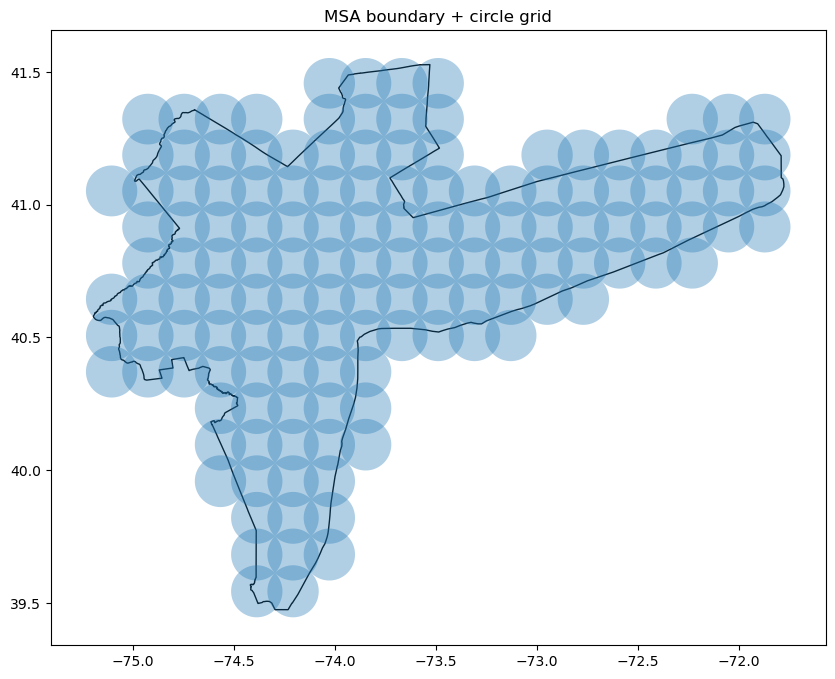

In [25]:
import matplotlib.pyplot as plt

# 确保 CRS 一致（强烈建议都用 EPSG:4326）
msa_ny_4326 = msa_ny.to_crs("EPSG:4326")
circles_4326 = circles.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

msa_ny_4326.plot(ax=ax, linewidth=1, facecolor="none")     # 只画边界
circles_4326.plot(ax=ax, alpha=0.35, linewidth=0.5)        # 画圆

ax.set_title("MSA boundary + circle grid")
plt.show()


## Debug

In [50]:
import math
import time
import requests
import json
import warnings
from typing import Optional, Iterable, List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def read_token(token_path: str) -> str:
    """
    Read and return the token from a local JSON file.

    The function supports two valid JSON formats:
    1) An object with a "token" key: {"token": "xxxxx"}
    2) A plain string containing the token: "xxxxx"

    Parameters
    ----------
    token_path : str
        Local file path to the JSON file containing the token.

    Returns
    -------
    str
        The token string extracted from the file.

    Raises
    ------
    ValueError
        If the JSON file format is invalid or does not contain a valid token.
    """
    with open(token_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "token" in data:
        return data["token"]
    if isinstance(data, str):
        return data
    raise ValueError("Token JSON must be either a string or an object with a key 'token'.")


def circle_center(
    min_lon: float,
    max_lon: float,
    min_lat: float,
    max_lat: float,
    R: float,
    base: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:
    """
    Generate a grid of circle polygons inside a geographic bounding box.
    Returns circles in EPSG:4326 (lon/lat).

    If `base` is provided, return only circles that intersect `base`
    (via spatial join, predicate='intersects').

    Parameters
    ----------
    min_lon, max_lon, min_lat, max_lat : float
        Bounding box in EPSG:4326.
    R : float
        Grid half-spacing in meters (in EPSG:3857). Spacing is 2R.
        Each circle radius is R * sqrt(2) in meters (in EPSG:3857).
    base : geopandas.GeoDataFrame | None
        A GeoDataFrame used to filter circles by intersection.
        Will be reprojected to EPSG:4326 if needed.

    Returns
    -------
    geopandas.GeoDataFrame
        Circles (filtered if base is provided), in EPSG:4326.
    """
    # -----------------------------
    # 0) Basic input validation
    # -----------------------------
    if not (isinstance(min_lon, (int, float)) and isinstance(max_lon, (int, float))
            and isinstance(min_lat, (int, float)) and isinstance(max_lat, (int, float))):
        raise TypeError("min_lon, max_lon, min_lat, max_lat must be numeric (float or int).")
    if not (max_lon > min_lon and max_lat > min_lat):
        raise ValueError("max_lon must be > min_lon and max_lat must be > min_lat.")
    if not (isinstance(R, (int, float)) and R > 0):
        raise ValueError("R must be a positive number (meters).")

    if base is not None:
        if not isinstance(base, gpd.GeoDataFrame):
            raise TypeError("base must be a GeoDataFrame or None.")
        if base.geometry is None:
            raise ValueError("base must have a valid geometry column.")
        if base.crs is None:
            raise ValueError("base.crs is None. Please set a CRS on base before using it.")

    # -----------------------------
    # 1) Build bbox in EPSG:4326
    # -----------------------------
    poly_4326 = box(min_lon, min_lat, max_lon, max_lat)
    gdf_bbox_4326 = gpd.GeoDataFrame({"name": ["bbox_4326"]}, geometry=[poly_4326], crs="EPSG:4326")

    # -----------------------------
    # 2) Reproject bbox to EPSG:3857 (meters)
    # -----------------------------
    gdf_bbox_3857 = gdf_bbox_4326.to_crs(epsg=3857)
    minx, miny, maxx, maxy = gdf_bbox_3857.total_bounds

    # -----------------------------
    # 3) Grid centers inside bbox
    # -----------------------------
    xs = np.arange(minx + R, maxx + 1e-9, 2 * R)
    ys = np.arange(miny + R, maxy + 1e-9, 2 * R)

    if xs.size == 0 or ys.size == 0:
        warnings.warn("⚠️ No grid centers generated — check if R is too large or bbox too small.")
        centers_xy = np.empty((0, 2))
    else:
        xx, yy = np.meshgrid(xs, ys)
        centers_xy = np.column_stack([xx.ravel(), yy.ravel()])

    # -----------------------------
    # 4) Build circles in 3857 -> back to 4326
    # -----------------------------
    radius_m = R
    circles_3857 = [Point(cx, cy).buffer(radius_m, resolution=64) for (cx, cy) in centers_xy]
    circles = gpd.GeoDataFrame(geometry=circles_3857, crs="EPSG:3857").to_crs(epsg=4326)

    # -----------------------------
    # 5) Optional: filter circles by intersection with base
    # -----------------------------
    base_4326 = base.to_crs("EPSG:4326")
    circles_4326 = (
        gpd.sjoin(circles, base_4326, how="inner", predicate="intersects")
            .reset_index(drop=True)
    )
    circles_4326 = circles_4326[circles.columns]
    circles_m = circles_4326.to_crs(epsg=3857)
    centroids_m = circles_m.geometry.centroid
    centroids_ll = centroids_m.to_crs(epsg=4326)
    circles_4326["center_lon"] = centroids_ll.x
    circles_4326["center_lat"] = centroids_ll.y
    
    return circles_4326

def places_nearby_grid(
    circles: gpd.GeoDataFrame,
    *,
    token: str,
    R: float,
    place_types: List[str],
    field_mask: Iterable[str],
    max_result_count: int = 20,
    sleep_sec: float = 0.1,
) -> gpd.GeoDataFrame:
    """
    Query Google Places Nearby Search for each circle center.

    Parameters
    ----------
    circles : GeoDataFrame
        Must contain columns ['center_lon', 'center_lat'] in EPSG:4326.
    token : str
        Google Places API key.
    R : float
        Search radius in meters (should match circle_center R).
    place_types : list[str]
        includedPrimaryTypes sent to Google Places.
    field_mask : iterable[str]
        Fields requested via X-Goog-FieldMask.
    max_result_count : int, default 20
        Max results per query (Google cap).
    sleep_sec : float, default 0.1
        Sleep time between requests to avoid rate limiting.

    Returns
    -------
    GeoDataFrame
        POIs returned by Google Places Nearby Search (EPSG:4326).
    """

    url = "https://places.googleapis.com/v1/places:searchNearby"

    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": token,
        "X-Goog-FieldMask": ",".join(field_mask),
    }

    rows: List[Dict[str, Any]] = []

    for circle_id, row in circles.iterrows():
        lat = row["center_lat"]
        lon = row["center_lon"]

        payload = {
            "locationRestriction": {
                "circle": {
                    "center": {
                        "latitude": float(lat),
                        "longitude": float(lon),
                    },
                    "radius": float(R),
                }
            },
            "includedPrimaryTypes": place_types,
            "maxResultCount": int(max_result_count),
        }

        resp = requests.post(url, headers=headers, json=payload, timeout=30)
        data = resp.json()

        places = data.get("places", [])

        for p in places:
            rows.append({
                "circle_id": circle_id,
                "id": p.get("id"),
                "name": p.get("displayName", {}).get("text"),
                "address": p.get("formattedAddress"),
                "primary_type": p.get("primaryType"),
                "lat": p.get("location", {}).get("latitude"),
                "lon": p.get("location", {}).get("longitude"),
            })

        time.sleep(sleep_sec)

    df = pd.DataFrame(rows)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["lon"], df["lat"]),
        crs="EPSG:4326",
    )

    return gdf

In [59]:
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")
R = 5000  # meters

circles = circle_center(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny
)
circles

,geometry,center_lon,center_lat
0,"POLYGON ((-74.38701 39.50987, -74.38703 39.509...",-74.431930,39.509868
1,"POLYGON ((-74.29718 39.50987, -74.29720 39.509...",-74.342098,39.509868
2,"POLYGON ((-74.20735 39.50987, -74.20736 39.509...",-74.252267,39.509868
3,"POLYGON ((-74.11752 39.50987, -74.11753 39.509...",-74.162435,39.509868
4,"POLYGON ((-74.38701 39.57914, -74.38703 39.578...",-74.431930,39.579140
...,...,...,...
452,"POLYGON ((-73.84803 41.49056, -73.84804 41.489...",-73.892941,41.490563
453,"POLYGON ((-73.75819 41.49056, -73.75821 41.489...",-73.803109,41.490563
454,"POLYGON ((-73.66836 41.49056, -73.66838 41.489...",-73.713278,41.490563
455,"POLYGON ((-73.57853 41.49056, -73.57854 41.489...",-73.623446,41.490563


In [137]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "asian_grocery_store",
    "auto_parts_store",
    "bicycle_store",
    "book_store",
    "butcher_shop",
    "cell_phone_store",
    "clothing_store",
    "convenience_store",
    "department_store",
    "discount_store",
    "electronics_store",
    "food_store",
    "furniture_store",
    "gift_shop",
    "grocery_store",
    "hardware_store",
    "home_goods_store",
    "home_improvement_store",
    "jewelry_store",
    "liquor_store",
    "market",
    "pet_store",
    "shoe_store",
    "shopping_mall",
    "sporting_goods_store",
    "store",
    "supermarket",
    "warehouse_store",
    "wholesaler",
]

google_shop_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_shop_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJ0xCGpXvkwIkRI1wmjpqvFIg,Smithville Peanut Butter Company,"615 E Moss Mill Rd #55, Smithville, NJ 08205, USA",store,39.495509,-74.461318,POINT (-74.46132 39.49551)
1,0,ChIJuzPvpWDkwIkRUfQtSj9gEqc,Days Of Olde Antique Center,"150 S New York Rd, Galloway, NJ 08205, USA",home_goods_store,39.476540,-74.459701,POINT (-74.45970 39.47654)
2,0,ChIJ_1y3gXzkwIkRElyvxEFt5rM,Smithville Bakery,"3 N New York Rd, Galloway, NJ 08205, USA",bakery,39.494955,-74.459175,POINT (-74.45918 39.49496)
3,0,ChIJFbsO2WXkwIkR5nx8QY5MK5E,Smithville Square,"45 S New York Rd, Galloway, NJ 08205, USA",shopping_mall,39.487814,-74.462418,POINT (-74.46242 39.48781)
4,0,ChIJ8RAcenzkwIkRCzT3nHlQ0D0,CVS,"1 S New York Rd, Galloway, NJ 08205, USA",drugstore,39.493650,-74.458376,POINT (-74.45838 39.49365)
...,...,...,...,...,...,...,...,...
6967,456,ChIJnY_vk3RX3YkRnZNBYgWmlxU,Haviland Deli Cafe,"105 Haviland Dr Apartment A, Patterson, NY 125...",deli,41.461239,-73.546092,POINT (-73.54609 41.46124)
6968,456,ChIJZRuSAjVW3YkRiuYq5ZACEgo,Candlewood Drugs,"11 CT-37 # 6, New Fairfield, CT 06812, USA",pharmacy,41.466107,-73.486486,POINT (-73.48649 41.46611)
6969,456,ChIJ985kfchW3YkRkp45mMwC12c,Uncle Louie G Italian Ice & Ice Cream,"69 Fairfield Dr, Patterson, NY 12563, USA",ice_cream_shop,41.460343,-73.548193,POINT (-73.54819 41.46034)
6970,456,ChIJBcPWJ9lQ3YkR6zj9GiO_Gds,Patterson Auto Body Convenience Store,"2597 NY-22, Patterson, NY 12563, USA",convenience_store,41.483927,-73.576326,POINT (-73.57633 41.48393)


In [ ]:
google_shop_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_shop_5000.geojson', driver="GeoJSON")

In [64]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "car_dealer",
    "car_rental",
    "car_repair",
    "car_wash",
    "electric_vehicle_charging_station",
    "gas_station",
    "parking",
    "rest_stop",
]

google_automotive_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_automotive_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,POINT (-74.45783 39.49122)
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,POINT (-74.46091 39.47225)
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,POINT (-74.46549 39.47692)
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,POINT (-74.26248 39.53222)
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,POINT (-74.26293 39.53147)
...,...,...,...,...,...,...,...,...
6225,456,ChIJ70tw88hW3YkR9559d3Qk1w8,Epm Mart,"56 Fairfield Dr, Patterson, NY 12563, USA",gas_station,41.460702,-73.549251,POINT (-73.54925 41.46070)
6226,456,ChIJfcMQYshW3YkRDk2lmFKkKHM,3600 Corporation,"Putnam Lake, NY 10509, USA",car_repair,41.460190,-73.548690,POINT (-73.54869 41.46019)
6227,456,ChIJh2WPr1NX3YkRfCyeAeOTJhk,New Fairfield Park & Ride,"302 Ball Pond Rd, New Fairfield, CT 06812, USA",park_and_ride,41.464642,-73.494532,POINT (-73.49453 41.46464)
6228,456,ChIJUd3sJgBX3YkRgazd0Lyvb2I,ChargePoint Charging Station,"185 Fairfield Dr, Brewster, NY 10509, USA",electric_vehicle_charging_station,41.454942,-73.540070,POINT (-73.54007 41.45494)


In [65]:
google_automotive_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_automotive_5000.geojson', driver="GeoJSON")

In [66]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "corporate_office",
    "farm",
    "ranch",
]

google_business_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_business_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJg4b54qTjwIkR_FIuvaX_O70,Nacote Creek Research Station,"360 N New York Rd, Galloway, NJ 08205, USA",corporate_office,39.529387,-74.461534,POINT (-74.46153 39.52939)
1,0,ChIJgRLCDpXjwIkR-_954QG-ESg,Honey and Sweet,"540 Chestnut Neck Rd, Port Republic, NJ 08241,...",farm,39.539539,-74.472977,POINT (-74.47298 39.53954)
2,0,ChIJiR2RpHvkwIkRkY0t4xSzv-0,Tomasello Winery - Village Greene,"615 E Moss Mill Rd #75, Galloway, NJ 08205, USA",farm,39.495607,-74.460327,POINT (-74.46033 39.49561)
3,2,ChIJH1pJvc1APm0Rtkuct5_HItQ,Tiny Shack Farm,"5614 West Ave, Long Beach, NJ 08008, USA",farm,39.532290,-74.265143,POINT (-74.26514 39.53229)
4,4,ChIJo3ZqaEIdwYkRfy0G7lKcthQ,BayFarm INC,"US-9, New Gretna, NJ 08224, USA",farm,39.592266,-74.427762,POINT (-74.42776 39.59227)
...,...,...,...,...,...,...,...,...
4726,455,ChIJZy2iBXRa3YkRZWEK76S7BUk,Ohio Rubber Mulch,"31 NY-22 Suite 11, Pawling, NY 12564, USA",corporate_office,41.526491,-73.588224,POINT (-73.58822 41.52649)
4727,456,ChIJrdnR2yxX3YkRBxEc_LvaWW0,Ridge Ranch,"276 Quaker Rd, Patterson, NY 12563, USA",farm,41.487332,-73.537018,POINT (-73.53702 41.48733)
4728,456,ChIJLRn6lbZW3YkRa51tMmT_3uA,Green Chimneys Farm & Wildlife Center,"400 Doansburg Rd, Brewster, NY 10509, USA",farm,41.454738,-73.552378,POINT (-73.55238 41.45474)
4729,456,ChIJn7UcKFRX3YkRqElX7aLfDEM,Cozy Oak Gardens,"4 Byebrook Ct, New Fairfield, CT 06812, USA",farm,41.490952,-73.510900,POINT (-73.51090 41.49095)


In [67]:
google_business_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_business_5000.geojson', driver="GeoJSON")

In [69]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "art_gallery",
    "art_studio",
    "auditorium",
    "cultural_landmark",
    "historical_place",
    "monument",
    "museum",
    "performing_arts_theater",
    "sculpture",
]

google_culture_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_culture_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJG5eP1MHlwIkRr9U1vJiS1os,Historic Towne of Smithville,"Route 9 &, E Moss Mill Rd, Smithville, NJ 0820...",historical_landmark,39.493889,-74.457649,POINT (-74.45765 39.49389)
1,0,ChIJCZRG4FLiwIkRxHX6DFQWsb4,Chestnut Neck Battle Monument,"Port Republic, NJ 08241, USA",historical_landmark,39.544570,-74.461465,POINT (-74.46147 39.54457)
2,0,ChIJ8QQBxmXjwIkRtEchPQW_9uI,Nacote Creek BrIdge,"1 S Old New York Rd, Port Republic, NJ 08241, USA",historical_landmark,39.515968,-74.484604,POINT (-74.48460 39.51597)
3,0,ChIJgwpQMCPlwIkRlxCcXFTbXno,Smithville Grist Mill,"3 N New York Rd Ste 19, Galloway, NJ 08205, USA",historical_landmark,39.494713,-74.460121,POINT (-74.46012 39.49471)
4,1,ChIJJcUTSkj8wIkR7tIsy6Cc4ao,Fish Factory,"Little Egg Harbor Township, NJ 08087, USA",historical_landmark,39.518291,-74.336813,POINT (-74.33681 39.51829)
...,...,...,...,...,...,...,...,...
4275,455,ChIJVSsVeORP3YkRfpaVA_yOYMw,Darwin Erazo | Visual arts,"6 Woodstock Rd, Carmel Hamlet, NY 10512, USA",art_studio,41.466448,-73.655253,POINT (-73.65525 41.46645)
4276,455,ChIJ__9rpAZQ3YkRmgf_QbyURmY,The SLAB ceramic art studio,"252 NY-292, Holmes, NY 12531, USA",art_studio,41.526122,-73.646699,POINT (-73.64670 41.52612)
4277,456,ChIJBwN4XZlW3YkRjcrxu-wXtBA,David Boyajian Sculpture,"3 Milltown Rd, Danbury, CT 06811, USA",art_gallery,41.445953,-73.526236,POINT (-73.52624 41.44595)
4278,456,ChIJARCTt0pW3YkRbHV3-OGNBRM,Hubbell House Museum,"33-39 Pembroke Rd, New Fairfield, CT 06812, USA",museum,41.468213,-73.489019,POINT (-73.48902 41.46821)


In [70]:
google_culture_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_culture_5000.geojson', driver="GeoJSON")

In [71]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "library",
    "preschool",
    "primary_school",
    "school",
    "secondary_school",
    "university",
]

google_education_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_education_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJPbIuD17kwIkR16MeDJOlDmg,Atlantic Community Charter School,"112 S New York Rd, Galloway, NJ 08205, USA",school,39.481662,-74.458442,POINT (-74.45844 39.48166)
1,0,ChIJk8lVw2zkwIkRmjiTYJ3hZLk,Smithville Elementary School,"37 S Old Port Rd, Galloway, NJ 08205, USA",primary_school,39.490123,-74.475757,POINT (-74.47576 39.49012)
2,0,ChIJE0vxz6_jwIkRGNjkto4xlE4,Stockton University Marine Field Station,"30 Wilson Ave, Port Republic, NJ 08241, USA",university,39.534917,-74.463237,POINT (-74.46324 39.53492)
3,0,ChIJ3X603K_jwIkReOM4kYSs4DQ,Stockton University Coastal Research Center,"30 Wilson Ave, Port Republic, NJ 08241, USA",university,39.534917,-74.463237,POINT (-74.46324 39.53492)
4,0,ChIJ_1-ndmbkwIkRjIk601P5XQM,Giggles & Scribbles,"45 S New York Rd, Galloway, NJ 08205, USA",school,39.487524,-74.462454,POINT (-74.46245 39.48752)
...,...,...,...,...,...,...,...,...
4819,456,ChIJI6xi-pFW3YkR-aWbV40hmHY,First Step Pre School Inc,"28 CT-39, New Fairfield, CT 06812, USA",preschool,41.467826,-73.483087,POINT (-73.48309 41.46783)
4820,456,ChIJVQyIj4NX3YkRx6UNPaPHs2U,NFMS ENTRANCE,"FF6R+XR, 54 Gillotti Rd, New Fairfield, CT 068...",school,41.460443,-73.505819,POINT (-73.50582 41.46044)
4821,456,ChIJE8ScjgxX3YkRiUO06bpIrhI,A thru G Music,"36 Newburgh Rd, Patterson, NY 12563, USA",school,41.473586,-73.551240,POINT (-73.55124 41.47359)
4822,456,ChIJ_____79X3YkRmOj3s7Yojqs,Flyfishing University,"PO Box 8885, New Fairfield, CT 06812, USA",university,41.479989,-73.500511,POINT (-73.50051 41.47999)


In [72]:
google_education_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_education_5000.geojson', driver="GeoJSON")

In [73]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "adventure_sports_center",
    "amphitheatre",
    "amusement_center",
    "amusement_park",
    "aquarium",
    "banquet_hall",
    "barbecue_area",
    "botanical_garden",
    "bowling_alley",
    "casino",
    "childrens_camp",
    "comedy_club",
    "community_center",
    "concert_hall",
    "convention_center",
    "cultural_center",
    "cycling_park",
    "dance_hall",
    "dog_park",
    "event_venue",
    "ferris_wheel",
    "garden",
    "hiking_area",
    "historical_landmark",
    "internet_cafe",
    "karaoke",
    "marina",
    "movie_rental",
    "movie_theater",
    "national_park",
    "night_club",
    "observation_deck",
    "off_roading_area",
    "opera_house",
    "park",
    "philharmonic_hall",
    "picnic_ground",
    "planetarium",
    "plaza",
    "roller_coaster",
    "skateboard_park",
    "state_park",
    "tourist_attraction",
    "video_arcade",
    "visitor_center",
    "water_park",
    "wedding_venue",
    "wildlife_park",
    "wildlife_refuge",
    "zoo",
]

google_entertainment_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_entertainment_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJnQmunbPjwIkRfm-m9kIoukQ,Thousand Trails Chestnut Lake,"631 Chestnut Neck Rd, Port Republic, NJ 08241,...",campground,39.541482,-74.469392,POINT (-74.46939 39.54148)
1,0,ChIJG5eP1MHlwIkRr9U1vJiS1os,Historic Towne of Smithville,"Route 9 &, E Moss Mill Rd, Smithville, NJ 0820...",historical_landmark,39.493889,-74.457649,POINT (-74.45765 39.49389)
2,0,ChIJ51JBJfblwIkR9g-50g_bgFM,Galloway Nature Preserve,"Galloway, NJ 08205, USA",park,39.483486,-74.469077,POINT (-74.46908 39.48349)
3,0,ChIJo1jyYm7kwIkRQ5jnxHH_p0Y,Smithville Community Center,"580 E Moss Mill Rd, Galloway, NJ 08205, USA",community_center,39.494832,-74.469390,POINT (-74.46939 39.49483)
4,0,ChIJmU5hCrDjwIkR11tUL84A-LI,Nacote Creek Marina,"1 New York Rd, Port Republic, NJ 08241, USA",marina,39.534098,-74.465515,POINT (-74.46551 39.53410)
...,...,...,...,...,...,...,...,...
7307,456,ChIJI8303cpX3YkRQcU2a0D2GYw,Dunham Pond,"New Fairfield, CT 06812, USA",park,41.469356,-73.486243,POINT (-73.48624 41.46936)
7308,456,ChIJ9zAn3ftX3YkRnOX5DFayDV0,Komlo Preserve,"Unnamed Road, New Fairfield, CT 06812, USA",hiking_area,41.468312,-73.487849,POINT (-73.48785 41.46831)
7309,456,ChIJI13hdgBX3YkRq1wPp5G0tCQ,Cranberry Mountain (parking area),"10-12 Brimstone Rd, Patterson, NY 12563, USA",hiking_area,41.490420,-73.546509,POINT (-73.54651 41.49042)
7310,456,ChIJ021nHABR3YkR_yKPdZKvGfg,Cranberry Mountain (parking),"Putnam Lake, NY 12563, USA",hiking_area,41.482232,-73.569308,POINT (-73.56931 41.48223)


In [74]:
google_entertainment_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_entertainment_5000.geojson', driver="GeoJSON")

In [75]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "public_bath",
    "public_bathroom",
    "stable",
]

google_facilities_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_facilities_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJc1jHEwDlwIkRCBAR7XF7wjI,Restrooms,"615 E Moss Mill Rd, Galloway, NJ 08205, USA",public_bathroom,39.495928,-74.460504,POINT (-74.46050 39.49593)
1,2,ChIJ66uGmrT_wIkRd6UbMGliZUA,Public Bathrooms,"5416 S Bay Ave, Long Beach, NJ 08008, USA",public_bathroom,39.532172,-74.262381,POINT (-74.26238 39.53217)
2,6,ChIJDZgBcQABwYkRn4dbqDO53xo,Public Restroom,"Beach Haven, NJ 08008, USA",public_bathroom,39.566716,-74.245022,POINT (-74.24502 39.56672)
3,6,ChIJk4V8GdABwYkRnIHcV-qaf3k,Public Restroom,"300 Pearl St, Beach Haven, NJ 08008, USA",public_bathroom,39.560798,-74.243162,POINT (-74.24316 39.56080)
4,9,ChIJvRksfrEGwYkRPMgbTuxisYk,A & T Stables,"382 Main St, West Creek, NJ 08092, USA",stable,39.646700,-74.296950,POINT (-74.29695 39.64670)
...,...,...,...,...,...,...,...,...
2042,455,ChIJg-lJb05Q3YkRVcpl3IL_JeE,Beaver Creek Equestrian Center,"683 NY-311, Patterson, NY 12563, USA",stable,41.493566,-73.620418,POINT (-73.62042 41.49357)
2043,455,ChIJa4VOYRZQ3YkRRxqxJgajBVc,FRS Equestrian,"490 Mooney Hill Rd, Patterson, NY 12563, USA",stable,41.511873,-73.637124,POINT (-73.63712 41.51187)
2044,456,ChIJQWC2j3xX3YkR0B2Y9Xpw0zw,High Point Equestrian Center,"572 E Branch Rd, Patterson, NY 12563, USA",stable,41.464982,-73.557480,POINT (-73.55748 41.46498)
2045,456,ChIJDRAfujdR3YkRUGK4LFF0uAI,High View Show Stables,"572 E Branch Rd, Patterson, NY 12563, USA",stable,41.464948,-73.557515,POINT (-73.55751 41.46495)


In [76]:
google_facilities_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_facilities_5000.geojson', driver="GeoJSON")

In [77]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "accounting",
    "atm",
    "bank",
]

google_finance_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_finance_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJ8RAcenzkwIkRdI_mEdcLW_o,Santander ATM,"1 S New York Rd CVS, Galloway, NJ 08205, USA",atm,39.493635,-74.458501,POINT (-74.45850 39.49363)
1,0,ChIJt0gT7czlwIkRMVAu13Vjk1g,PNC ATM,"8 S New York Rd, Absecon, NJ 08205, USA",atm,39.492249,-74.457530,POINT (-74.45753 39.49225)
2,0,ChIJU-BlSGHkwIkRgXS1_oXfeTY,Kondler & Associates,"48 S New York Rd B8, Galloway, NJ 08205, USA",consultant,39.486075,-74.457738,POINT (-74.45774 39.48608)
3,0,ChIJjXgzmJ3lwIkR_Tt0nWZukrM,LibertyX Bitcoin ATM,"1 S New York Rd CVS, Galloway, NJ 08205, USA",atm,39.493650,-74.458376,POINT (-74.45838 39.49365)
4,0,ChIJVWW5CKvlwIkRL3Wlt8KRUMk,Abdullahi Bookkeeping,"NA, Absecon, NJ 08205, USA",consultant,39.472808,-74.464302,POINT (-74.46430 39.47281)
...,...,...,...,...,...,...,...,...
5505,456,ChIJXbziqDVW3YkRFZnmjJiMG_o,New Fairfield Tax Collector,"4 Brush Hill Rd #2619, New Fairfield, CT 06812...",local_government_office,41.465514,-73.487032,POINT (-73.48703 41.46551)
5506,456,ChIJXbziqDVW3YkRU87OmKZcGI4,New Fairfield Land Trust Inc,"4 Brush Hill Rd, New Fairfield, CT 06812, USA",bank,41.465505,-73.487021,POINT (-73.48702 41.46550)
5507,456,ChIJZcOXr75X3YkRbex0_nwM4Sg,M&T Bank ATM,"25 CT-39, New Fairfield, CT 06812, USA",atm,41.468350,-73.484494,POINT (-73.48449 41.46835)
5508,456,ChIJ221ujDRW3YkR01zqBORwGbs,DAC CPA LLC,"86 CT-37, New Fairfield, CT 06812, USA",consultant,41.465827,-73.483733,POINT (-73.48373 41.46583)


In [78]:
google_finance_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_finance_5000.geojson', driver="GeoJSON")

In [79]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "acai_shop",
    "afghani_restaurant",
    "african_restaurant",
    "american_restaurant",
    "asian_restaurant",
    "bagel_shop",
    "bakery",
    "bar",
    "bar_and_grill",
    "barbecue_restaurant",
    "brazilian_restaurant",
    "breakfast_restaurant",
    "brunch_restaurant",
    "buffet_restaurant",
    "cafe",
    "cafeteria",
    "candy_store",
    "cat_cafe",
    "chinese_restaurant",
    "chocolate_factory",
    "chocolate_shop",
    "coffee_shop",
    "confectionery",
    "deli",
    "dessert_restaurant",
    "dessert_shop",
    "diner",
    "dog_cafe",
    "donut_shop",
    "fast_food_restaurant",
    "fine_dining_restaurant",
    "food_court",
]

google_food1_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_food1_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJ7bCvgXvkwIkRWjEHNN3_Pw4,The Smithville Inn,"1 N New York Rd, Galloway, NJ 08205, USA",american_restaurant,39.495208,-74.458015,POINT (-74.45801 39.49521)
1,0,ChIJ7bCvgXvkwIkRIbCCZmyKQyo,Fred and Ethel's Lantern Light Restaurant and ...,"1 N New York Rd, Galloway, NJ 08205, USA",american_restaurant,39.494592,-74.458881,POINT (-74.45888 39.49459)
2,0,ChIJW06mpXzkwIkRCFeHg_sv1gg,Wawa,"8 S New York Rd, Absecon, NJ 08205, USA",fast_food_restaurant,39.492257,-74.457599,POINT (-74.45760 39.49226)
3,0,ChIJfUsxA2TkwIkRjcWOnd2re4w,JD's Pub,"Square Shopping Center, 45 S New York Rd, Gall...",bar_and_grill,39.487655,-74.462967,POINT (-74.46297 39.48765)
4,0,ChIJXZSLuBVNx4kRt6AIvrHI3xA,Lakeside Grill,"615 E Moss Mill Rd, Smithville, NJ 08205, USA",american_restaurant,39.495634,-74.460258,POINT (-74.46026 39.49563)
...,...,...,...,...,...,...,...,...
5915,456,ChIJnY_vk3RX3YkRnZNBYgWmlxU,Haviland Deli Cafe,"105 Haviland Dr Apartment A, Patterson, NY 125...",deli,41.461239,-73.546092,POINT (-73.54609 41.46124)
5916,456,ChIJS4N2dElW3YkRkrZ4dKPM6wI,Main Moon,"28 CT-39, New Fairfield, CT 06812, USA",chinese_restaurant,41.467799,-73.483055,POINT (-73.48305 41.46780)
5917,456,ChIJ985kfchW3YkRkp45mMwC12c,Uncle Louie G Italian Ice & Ice Cream,"69 Fairfield Dr, Patterson, NY 12563, USA",ice_cream_shop,41.460343,-73.548193,POINT (-73.54819 41.46034)
5918,456,ChIJ9SMgPtlQ3YkRSgH_dcNbAcE,Patterson Deli,"2604 NY-22, Patterson, NY 12563, USA",deli,41.484599,-73.575509,POINT (-73.57551 41.48460)


In [80]:
google_food1_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_food1_5000.geojson', driver="GeoJSON")

In [81]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "french_restaurant",
    "greek_restaurant",
    "hamburger_restaurant",
    "ice_cream_shop",
    "indian_restaurant",
    "indonesian_restaurant",
    "italian_restaurant",
    "japanese_restaurant",
    "juice_shop",
    "korean_restaurant",
    "lebanese_restaurant",
    "meal_delivery",
    "meal_takeaway",
    "mediterranean_restaurant",
    "mexican_restaurant",
    "middle_eastern_restaurant",
    "pizza_restaurant",
    "pub",
    "ramen_restaurant",
    "restaurant",
    "sandwich_shop",
    "seafood_restaurant",
    "spanish_restaurant",
    "steak_house",
    "sushi_restaurant",
    "tea_house",
    "thai_restaurant",
    "turkish_restaurant",
    "vegan_restaurant",
    "vegetarian_restaurant",
    "vietnamese_restaurant",
    "wine_bar",
]

google_food2_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_food2_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJpUFzeFDjwIkRnsrhbDkn64g,Oyster Creek Restaurant And Boat Bar,"41 Oyster Creek Rd, Leeds Point, NJ 08220, USA",seafood_restaurant,39.504825,-74.416443,POINT (-74.41644 39.50483)
1,0,ChIJ7bCvgXvkwIkRWjEHNN3_Pw4,The Smithville Inn,"1 N New York Rd, Galloway, NJ 08205, USA",american_restaurant,39.495208,-74.458015,POINT (-74.45801 39.49521)
2,0,ChIJmQThw2zjwIkRPSjYrpLU8BE,Motts Creek Inn,"200 N Motts Creek Rd, Galloway, NJ 08205, USA",restaurant,39.518553,-74.436510,POINT (-74.43651 39.51855)
3,0,ChIJ7bCvgXvkwIkRIbCCZmyKQyo,Fred and Ethel's Lantern Light Restaurant and ...,"1 N New York Rd, Galloway, NJ 08205, USA",american_restaurant,39.494592,-74.458881,POINT (-74.45888 39.49459)
4,0,ChIJW06mpXzkwIkRCFeHg_sv1gg,Wawa,"8 S New York Rd, Absecon, NJ 08205, USA",fast_food_restaurant,39.492257,-74.457599,POINT (-74.45760 39.49226)
...,...,...,...,...,...,...,...,...
6128,456,ChIJrUTRFTVW3YkRnA2UVO4izEo,Olde 37 Patio & Grill,"25 CT-37, New Fairfield, CT 06812, USA",hamburger_restaurant,41.467065,-73.487779,POINT (-73.48778 41.46706)
6129,456,ChIJLw2wFU1X3YkRCco0-aInwuM,YOYO TEA & SWEETS,"28 CT-39 STE 10, New Fairfield, CT 06812, USA",tea_house,41.467799,-73.483055,POINT (-73.48305 41.46780)
6130,456,ChIJS4N2dElW3YkRkrZ4dKPM6wI,Main Moon,"28 CT-39, New Fairfield, CT 06812, USA",chinese_restaurant,41.467799,-73.483055,POINT (-73.48305 41.46780)
6131,456,ChIJ985kfchW3YkRkp45mMwC12c,Uncle Louie G Italian Ice & Ice Cream,"69 Fairfield Dr, Patterson, NY 12563, USA",ice_cream_shop,41.460343,-73.548193,POINT (-73.54819 41.46034)


In [82]:
google_food2_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_food2_5000.geojson', driver="GeoJSON")

In [83]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "city_hall",
    "courthouse",
    "embassy",
    "fire_station",
    "government_office",
    "local_government_office",
    "police",
    "post_office",
]

google_government_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_government_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJr_IuDVrkwIkR0jwGnNsDPYo,United States Postal Service,"174 S New York Rd, Oceanville, NJ 08231, USA",post_office,39.472757,-74.459808,POINT (-74.45981 39.47276)
1,0,ChIJg-6mPprkwIkRPh4I9G5qc-s,United States Postal Service,"15 Leeds Point Rd, Leeds Point, NJ 08220, USA",post_office,39.490763,-74.436091,POINT (-74.43609 39.49076)
2,0,ChIJBxdD71DkwIkRJ9_Cibz79Dc,Oceanville Volunteer Fire Co #1,"186 S New York Rd, Galloway, NJ 08205, USA",fire_station,39.470833,-74.460680,POINT (-74.46068 39.47083)
3,2,ChIJxYzAT9j_wIkRJ3pkXSuMOqg,Beach Haven Borough-Emergency,"420 Pelham Ave, Beach Haven, NJ 08008, USA",local_government_office,39.552623,-74.250992,POINT (-74.25099 39.55262)
4,2,ChIJC5ARDNr_wIkRzpRKJPRAF3g,Beach Haven Sewerage Office,"340 Nelson Ave, Beach Haven, NJ 08008, USA",local_government_office,39.548411,-74.252516,POINT (-74.25252 39.54841)
...,...,...,...,...,...,...,...,...
5825,456,ChIJXbziqDVW3YkRkOKJ-fyghv0,New Fairfield Assessor's Office,"4 Brush Hill Rd #2619, New Fairfield, CT 06812...",local_government_office,41.465505,-73.487021,POINT (-73.48702 41.46550)
5826,456,ChIJXbziqDVW3YkReyQEyC_uEaY,New Fairfield Conservation,"4 Brush Hill Rd #2619, New Fairfield, CT 06812...",health,41.465505,-73.487021,POINT (-73.48702 41.46550)
5827,456,ChIJXbziqDVW3YkRNbHpPEyYNjw,New Fairfield Registrar-Voters,"4 Brush Hill Rd #2619, New Fairfield, CT 06812...",local_government_office,41.465505,-73.487021,POINT (-73.48702 41.46550)
5828,456,ChIJGXlRrzVW3YkR6ukzvRgMlEE,New Fairfield Finance Department,"3 Brush Hill Rd, New Fairfield, CT 06812, USA",local_government_office,41.465282,-73.486175,POINT (-73.48618 41.46528)


In [84]:
google_government_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_government_5000.geojson', driver="GeoJSON")

In [85]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "chiropractor",
    "dental_clinic",
    "dentist",
    "doctor",
    "drugstore",
    "hospital",
    "massage",
    "medical_lab",
    "pharmacy",
    "physiotherapist",
    "sauna",
    "skin_care_clinic",
    "spa",
    "tanning_studio",
    "wellness_center",
    "yoga_studio",
]

google_health_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_health_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJ8RAcenzkwIkRCzT3nHlQ0D0,CVS,"1 S New York Rd, Galloway, NJ 08205, USA",drugstore,39.493650,-74.458376,POINT (-74.45838 39.49365)
1,0,ChIJU-BlSGHkwIkR_CuJ_8V2pm4,"CHOP Pediatric Primary Care, Smithville","48 S New York Rd, Galloway, NJ 08205, USA",doctor,39.485485,-74.458511,POINT (-74.45851 39.48548)
2,0,ChIJU-BlSGHkwIkRcQ5XI3CMMbw,"Craig S. Puchalsky, DDS @ Smithville Smiles","48 S New York Rd Suite C-1, Galloway, NJ 08205...",dentist,39.485828,-74.458218,POINT (-74.45822 39.48583)
3,0,ChIJiy-gn1DkwIkROMJjK3ya-eI,Sperling Medical Associates,"182 S New York Rd, Galloway, NJ 08205, USA",doctor,39.472467,-74.459844,POINT (-74.45984 39.47247)
4,0,ChIJrR_bn3zkwIkR_wgTDJX_6-c,CVS Pharmacy,"1 S New York Rd, Galloway, NJ 08205, USA",pharmacy,39.493650,-74.458376,POINT (-74.45838 39.49365)
...,...,...,...,...,...,...,...,...
6319,456,ChIJByxRg4JX3YkRxJwNW7z22hc,"Armenia Mordan Vasquez, MD","130 CT-37, New Fairfield, CT 06812, USA",doctor,41.468657,-73.488030,POINT (-73.48803 41.46866)
6320,456,ChIJI2mnkzRW3YkRZZfgQdsBnCU,New Fairfield Chiropractic Center,"88 CT-37, New Fairfield, CT 06812, USA",chiropractor,41.466133,-73.484172,POINT (-73.48417 41.46613)
6321,456,ChIJ0-yCKxpX3YkRZPfHZfKjCuo,"Renee K. DeRosa, MD","130 CT-37, New Fairfield, CT 06812, USA",doctor,41.468565,-73.488044,POINT (-73.48804 41.46857)
6322,456,ChIJc_WBMbNX3YkRn_Gqck1X9wo,"William J. Kaplan, DO","130 CT-37, New Fairfield, CT 06812, USA",doctor,41.468565,-73.488044,POINT (-73.48804 41.46857)


In [86]:
google_health_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_health_5000.geojson', driver="GeoJSON")

In [87]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "beach",
]

google_nature_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_nature_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,1,ChIJVfCPrff7wIkRJ9WojFSdNv8,Island Beach,"Island Beach, Galloway, NJ, USA",beach,39.482340,-74.326256,POINT (-74.32626 39.48234)
1,1,ChIJXXy5Nff7wIkRAR6jnXtm704,Little Beach,"Little Beach, Galloway, NJ, USA",beach,39.479284,-74.325144,POINT (-74.32514 39.47928)
2,2,ChIJDQBbdyAAwYkRMum869JIJEg,Public Beach,"Public Beach, New Jersey 08008, USA",beach,39.555014,-74.241226,POINT (-74.24123 39.55501)
3,2,ChIJY1c8H17_wIkRCWxaLjloEZs,Kentford Beach,"Kentford Beach, 0 Kentford Ave, Beach Haven, N...",beach,39.549388,-74.248295,POINT (-74.24830 39.54939)
4,6,ChIJDQBbdyAAwYkRMum869JIJEg,Public Beach,"Public Beach, New Jersey 08008, USA",beach,39.555014,-74.241226,POINT (-74.24123 39.55501)
...,...,...,...,...,...,...,...,...
443,435,ChIJgenRHTPi5YkRhXzXVk8em3w,DuBois Beach,"Dubois Beach, Stonington, CT 06378, USA",beach,41.328433,-71.906460,POINT (-71.90646 41.32843)
444,437,ChIJNaCtV0NPw4kR-vQiH1ubpTI,West End Beach,"West End Beach, 14 Ferry St, Port Jervis, NY 1...",beach,41.377120,-74.704586,POINT (-74.70459 41.37712)
445,441,ChIJ8Q8rkLi0wokRu1nB_Bnn-Yg,Lake MacGregor Beach (Private),"Lake MacGregor Beach (Private), 238 Beach Dr, ...",beach,41.379712,-73.770410,POINT (-73.77041 41.37971)
446,445,ChIJM5rCvnUz3YkRDg_PrJFtSvU,Teenside Waterfront,"Teenside Waterfront, Philipstown, NY 10516, USA",beach,41.456660,-73.955338,POINT (-73.95534 41.45666)


In [88]:
google_nature_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_nature_5000.geojson', driver="GeoJSON")

In [89]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "church",
    "hindu_temple",
    "mosque",
    "synagogue",
]

google_places_worship_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_places_worship_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJvzER23zkwIkRgY7LWwgGO-M,Emmaus United Methodist Church,"706 E Moss Mill Rd, Galloway, NJ 08205, USA",church,39.493545,-74.456413,POINT (-74.45641 39.49355)
1,0,ChIJ_44D_prkwIkRDg2U-sKWGC0,Leeds Community Church,"850 E Moss Mill Rd, Galloway, NJ 08205, USA",church,39.492162,-74.438053,POINT (-74.43805 39.49216)
2,0,ChIJEYUHWgDlwIkRj8LYFS1KToY,Cornerstone Fellowship,"140 S New York Rd, Galloway, NJ 08205, USA",church,39.477495,-74.459454,POINT (-74.45945 39.47749)
3,4,ChIJEScyAngdwYkRwRHQd3I4Wfk,St Paul's United Methodist Church,"5630 US-9, New Gretna, NJ 08224, USA",church,39.591468,-74.455452,POINT (-74.45545 39.59147)
4,4,ChIJMQyZ3sECwYkRlUyAT2Al9mc,Good Shepherd Lutheran Church,"500 Mathistown Rd, Tuckerton, NJ 08087, USA",church,39.596661,-74.382593,POINT (-74.38259 39.59666)
...,...,...,...,...,...,...,...,...
4869,456,ChIJRSQe809W3YkRH7pprZvh7x0,Congregational Church of New Fairfield,"20 Gillotti Rd, New Fairfield, CT 06812, USA",church,41.462493,-73.495942,POINT (-73.49594 41.46249)
4870,456,ChIJC6olgKNX3YkRA4KVEpe9s3Y,New Life United Methodist Church,"1 Beaver Bog Rd, New Fairfield, CT 06812, USA",church,41.485947,-73.504150,POINT (-73.50415 41.48595)
4871,456,ChIJNX2iydhW3YkRhv1RyDTa2Q4,New Life Christian Church,"29 Marshall Ct, Patterson, NY 12563, USA",church,41.475027,-73.542207,POINT (-73.54221 41.47503)
4872,456,ChIJ_VvFUwBR3YkRFnn0RDIX5Xs,Kingdom Hall of Jehovah's Witnesses--Heritage ...,"100 Watchtower Dr, Patterson, NY 12563, USA",church,41.496986,-73.576277,POINT (-73.57628 41.49699)


In [90]:
google_places_worship_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_places_worship_5000.geojson', driver="GeoJSON")

In [91]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "astrologer",
    "barber_shop",
    "beautician",
    "beauty_salon",
    "body_art_service",
    "catering_service",
    "cemetery",
    "child_care_agency",
    "consultant",
    "courier_service",
    "electrician",
    "florist",
    "food_delivery",
    "foot_care",
    "funeral_home",
    "hair_care",
    "hair_salon",
    "insurance_agency",
    "laundry",
    "lawyer",
    "locksmith",
    "makeup_artist",
    "moving_company",
    "nail_salon",
    "painter",
    "plumber",
    "psychic",
    "real_estate_agency",
    "roofing_contractor",
    "storage",
    "summer_camp_organizer",
    "tailor",
    "telecommunications_service_provider",
    "tour_agency",
    "tourist_information_center",
    "travel_agency",
    "veterinary_care",
]

google_services_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_services_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJDVPZ0CrlwIkRCg0WA8kEuzo,LaBelle Spa & Nails,"168 S New York Rd, Galloway, NJ 08205, USA",nail_salon,39.472869,-74.459970,POINT (-74.45997 39.47287)
1,0,ChIJ_93Fu3PlwIkRjjog4E4l1OY,Ultima Tattoo and Piercing,"160 S New York Rd C4, Galloway, NJ 08205, USA",body_art_service,39.473554,-74.460142,POINT (-74.46014 39.47355)
2,0,ChIJXejyGmLkwIkRjQvMzb--gfs,iStorage,"36 S New York Rd, Smithville, NJ 08205, USA",storage,39.487861,-74.457803,POINT (-74.45780 39.48786)
3,0,ChIJ9WhQyUTlwIkRh_BA8ht1iRM,Calvin Chan - GEICO Insurance Agent,"45 S New York Rd Suite 218, Galloway, NJ 08205...",insurance_agency,39.488309,-74.464561,POINT (-74.46456 39.48831)
4,0,ChIJR9QubbvlwIkRKBOzcfh3gjo,Hair Haven,"166 S New York Rd, Galloway, NJ 08205, USA",hair_salon,39.472877,-74.460025,POINT (-74.46003 39.47288)
...,...,...,...,...,...,...,...,...
7068,456,ChIJS4N2dElW3YkR0LnlCh_U4v8,Superior Cleaners & Tailors,"88 CT-37, New Fairfield, CT 06812, USA",laundry,41.466133,-73.484172,POINT (-73.48417 41.46613)
7069,456,ChIJYWOMJu1f3YkRVODPQ3eCbOA,Alvaro Plumbing & Heating,"2237 NY-22, Patterson, NY 12563, USA",plumber,41.463070,-73.580185,POINT (-73.58019 41.46307)
7070,456,ChIJg4dPKi1X3YkRKMY2ushiMjQ,Camille Skincare & Spa,"1 Brush Hill Rd, New Fairfield, CT 06812, USA",beauty_salon,41.465225,-73.485272,POINT (-73.48527 41.46523)
7071,456,ChIJJ6iMIJBW3YkRue_4TxC3l_A,One Stop Cleaners,"15 CT-39, New Fairfield, CT 06812, USA",laundry,41.467509,-73.486044,POINT (-73.48604 41.46751)


In [92]:
google_services_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_services_5000.geojson', driver="GeoJSON")

In [93]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "arena",
    "athletic_field",
    "fishing_charter",
    "fishing_pond",
    "fitness_center",
    "golf_course",
    "gym",
    "ice_skating_rink",
    "playground",
    "ski_resort",
    "sports_activity_location",
    "sports_club",
    "sports_coaching",
    "sports_complex",
    "stadium",
    "swimming_pool",
]

google_sport_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_sport_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJRTGCC2bkwIkRS1gidZdTfaU,Anytime Fitness,"45 S New York Rd, Galloway, NJ 08205, USA",gym,39.487530,-74.463343,POINT (-74.46334 39.48753)
1,0,ChIJSb0Aqm_kwIkR73RMNhuaLtk,Four Seasons Active Adult Recreation Center,"550 Smithville Blvd, Galloway, NJ 08205, USA",sports_activity_location,39.490680,-74.466036,POINT (-74.46604 39.49068)
2,0,ChIJ_x2uOE3lwIkR9dqC8fmLfCI,Outlast Fitness,"160 S New York Rd, Galloway, NJ 08205, USA",gym,39.473683,-74.460211,POINT (-74.46021 39.47368)
3,0,ChIJDRTymjXpwIkRejq9PKjIkog,Oy Boy Fighting Systems at Freestyle Martial Arts,"Smithville, NJ 08205, USA",sports_activity_location,39.494482,-74.460623,POINT (-74.46062 39.49448)
4,0,ChIJw29FgzTlwIkR-8PLnLXX3-c,CDR Taekwondo,"731 Great Creek Rd, Galloway, NJ 08205, USA",sports_activity_location,39.469107,-74.455333,POINT (-74.45533 39.46911)
...,...,...,...,...,...,...,...,...
6667,456,ChIJnaSDezNW3YkR0IK98c6GZhw,World Champion Taekwondo New Fairfield,"28 CT-39, New Fairfield, CT 06812, USA",sports_activity_location,41.467747,-73.483148,POINT (-73.48315 41.46775)
6668,456,ChIJ8cfoeFBW3YkRyDSv_lQB92w,Rebel Turf,"FF6R+XR, 54 Gillotti Rd, New Fairfield, CT 068...",athletic_field,41.460958,-73.502965,POINT (-73.50296 41.46096)
6669,456,ChIJ55j4QwBX3YkRGPfdRRbgHtw,"Hahlawah Preserve, CVRLT Property","47 Ball Pond Rd E, New Fairfield, CT 06812, USA",hiking_area,41.464250,-73.520300,POINT (-73.52030 41.46425)
6670,456,ChIJPcgm4AJX3YkRDcEUS4cLinA,Upper Multi Purpose Field.,"54 Gillotti Rd, New Fairfield, CT 06812, USA",athletic_field,41.460786,-73.509114,POINT (-73.50911 41.46079)


In [94]:
google_sport_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_sport_5000.geojson', driver="GeoJSON")

In [95]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
]

place_types = [
    "airport",
    "airstrip",
    "bus_station",
    "bus_stop",
    "ferry_terminal",
    "heliport",
    "international_airport",
    "light_rail_station",
    "park_and_ride",
    "subway_station",
    "taxi_stand",
    "train_station",
    "transit_depot",
    "transit_station",
    "truck_stop",
]

google_transportation_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_transportation_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJAQB9Y3zkwIkRwKvoG5krLng,Us-9 360'n of Moss Mill Rd,"Galloway, NJ 08205, USA",bus_stop,39.495350,-74.457470,POINT (-74.45747 39.49535)
1,0,ChIJsbw8YmPkwIkRkEr1u5ndDeM,Rt-9 at Quail Hill Blvd,"Galloway, NJ 08205, USA",bus_stop,39.490650,-74.458313,POINT (-74.45831 39.49065)
2,0,ChIJr7zDh3zkwIkR0yVQQJGGYjE,Us-9 465's of Old New York Rd,"Galloway, NJ 08205, USA",bus_stop,39.494840,-74.457690,POINT (-74.45769 39.49484)
3,0,ChIJ7QzbXYPjwIkRHcsMSh5pGSc,Us-9 at Motts Creek Rd,"Galloway, NJ 08205, USA",bus_stop,39.511377,-74.457950,POINT (-74.45795 39.51138)
4,0,ChIJEzTB6VLiwIkRTzDXb88ZLK8,Us-9 at Chestnut Neck Rd#,"Port Republic, NJ 08241, USA",bus_stop,39.544650,-74.462341,POINT (-74.46234 39.54465)
...,...,...,...,...,...,...,...,...
4621,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,POINT (-73.67959 41.50706)
4622,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,POINT (-73.60427 41.51174)
4623,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,POINT (-73.64332 41.47425)
4624,456,ChIJ4aKDlA5X3YkRjBvkwvIcC6Y,Ball Pond Firehouse Park & Ride,"7 Fairfield Dr, New Fairfield, CT 06812, USA",park_and_ride,41.456849,-73.528357,POINT (-73.52836 41.45685)


In [96]:
google_transportation_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_transportation_5000.geojson', driver="GeoJSON")

In [140]:
datasets = {
    "automotive": google_automotive_5000,
    "business": google_business_5000,
    "culture": google_culture_5000,
    "education": google_education_5000,
    "entertainment": google_entertainment_5000,
    "facilities": google_facilities_5000,
    "finance": google_finance_5000,
    "food": google_food1_5000,
    "food": google_food2_5000,
    "government": google_government_5000,
    "health": google_health_5000,
    "nature": google_nature_5000,
    "worship": google_places_worship_5000,
    "services": google_services_5000,
    "shop": google_shop_5000,
    "sport": google_sport_5000,
    "transportation": google_transportation_5000,
}

# Add primary_cat to each GeoDataFrame
for cat, gdf in datasets.items():
    gdf["primary_cat"] = cat

google_placescat_5000 = gpd.GeoDataFrame(
    pd.concat(list(datasets.values()), ignore_index=True),
    crs=google_automotive_5000.crs
)
google_placescat_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry,primary_cat
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,POINT (-74.45783 39.49122),automotive
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,POINT (-74.46091 39.47225),automotive
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,POINT (-74.46549 39.47692),automotive
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,POINT (-74.26248 39.53222),automotive
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,POINT (-74.26293 39.53147),automotive
...,...,...,...,...,...,...,...,...,...
83881,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,POINT (-73.67959 41.50706),transportation
83882,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,POINT (-73.60427 41.51174),transportation
83883,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,POINT (-73.64332 41.47425),transportation
83884,456,ChIJ4aKDlA5X3YkRjBvkwvIcC6Y,Ball Pond Firehouse Park & Ride,"7 Fairfield Dr, New Fairfield, CT 06812, USA",park_and_ride,41.456849,-73.528357,POINT (-73.52836 41.45685),transportation


In [142]:
google_placescat_5000.to_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_placescat_5000.geojson', driver="GeoJSON")

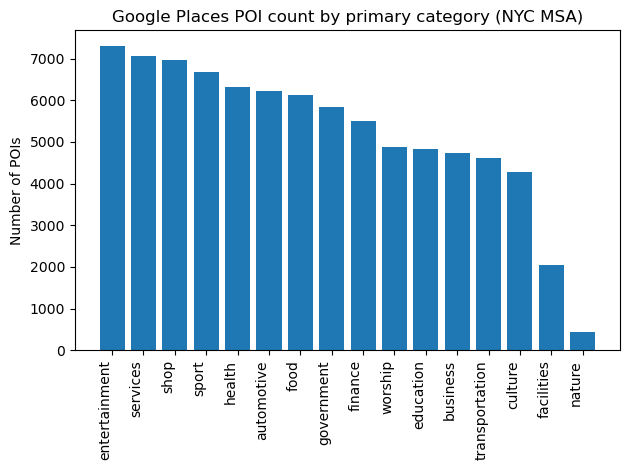

In [189]:
import matplotlib.pyplot as plt

counts = (
    google_placescat_5000
    .groupby("primary_cat")
    .size()
    .sort_values(ascending=False)
)

plt.figure()
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90, ha="right")
plt.ylabel("Number of POIs")
plt.title("Google Places POI count by primary category (NYC MSA)")
plt.tight_layout()
plt.show()


In [190]:
import pandas as pd

# 每个 (primary_cat, circle_id) 对应的 POI 数
cat_circle_counts = (
    google_placescat_5000
    .groupby(["primary_cat", "circle_id"])
    .size()
    .reset_index(name="n")
)
cat_circle_counts

,primary_cat,circle_id,n
0,automotive,0,3
1,automotive,2,3
2,automotive,4,6
3,automotive,5,20
4,automotive,6,12
...,...,...,...
5686,worship,452,11
5687,worship,453,2
5688,worship,454,3
5689,worship,455,6


In [191]:
def classify_circle(n):
    if n == 20:
        return "20"
    elif n < 15:
        return "1-15"
    else:
        return "15-19"
    
cat_circle_counts["bin"] = cat_circle_counts["n"].apply(classify_circle)
summary = (
    cat_circle_counts
    .groupby(["primary_cat", "bin"])
    .size()
    .unstack(fill_value=0)
)
summary['per_0'] = (len(circles)-(summary['1-15'] + summary['15-19'] + summary['20'])) / (len(circles))
summary['per_1_15'] = summary['1-15'] / (len(circles))
summary['per_15_19'] = summary['15-19'] / (len(circles))
summary['per_20'] = summary['20'] / (len(circles))
summary

bin,1-15,15-19,20,per_0,per_1_15,per_15_19,per_20
primary_cat,,,,,,,
automotive,96,18,267,0.166302,0.210066,0.039387,0.584245
business,166,41,152,0.214442,0.363239,0.089716,0.332604
culture,232,34,110,0.177243,0.507659,0.074398,0.240700
education,154,24,175,0.227571,0.336980,0.052516,0.382932
entertainment,54,33,318,0.113786,0.118162,0.072210,0.695842
facilities,272,10,35,0.306346,0.595186,0.021882,0.076586
finance,105,23,225,0.227571,0.229759,0.050328,0.492341
food,98,21,261,0.168490,0.214442,0.045952,0.571116
government,128,30,222,0.168490,0.280088,0.065646,0.485777


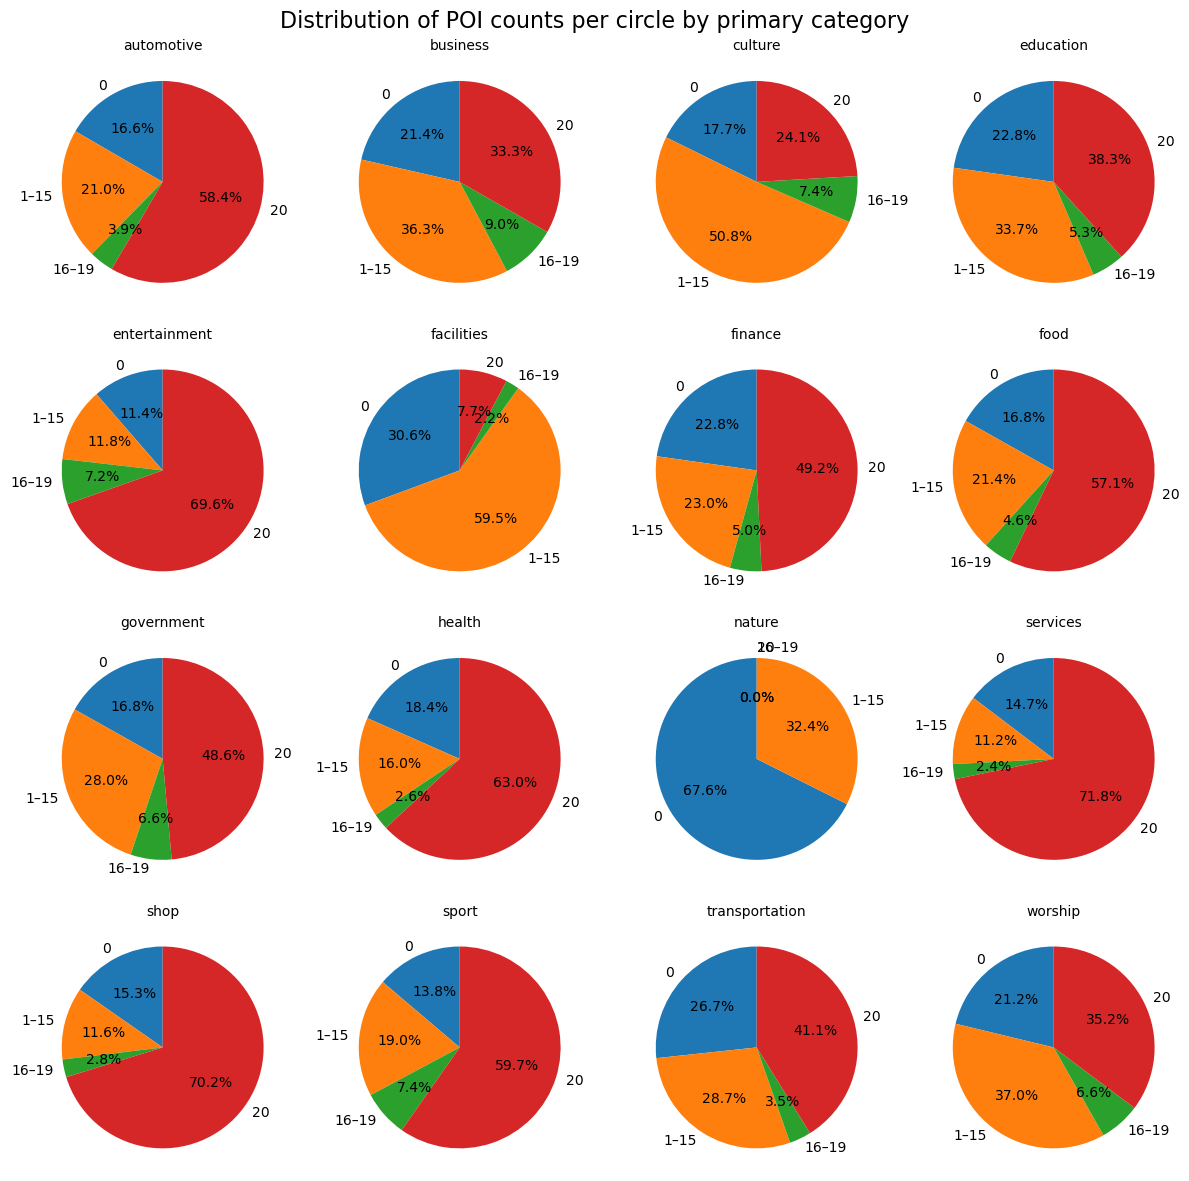

In [193]:
import matplotlib.pyplot as plt

cols = ['per_0', 'per_1_15', 'per_15_19', 'per_20']
labels = ['0', '1–15', '16–19', '20']

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, (cat, row) in zip(axes, summary[cols].iterrows()):
    ax.pie(
        row.values,
        labels=labels,
        autopct='%.1f%%',
        startangle=90
    )
    ax.set_title(cat, fontsize=10)
    ax.axis('equal')

# 如果 category 少于 16，关掉多余子图
for ax in axes[len(summary):]:
    ax.axis('off')

plt.suptitle("Distribution of POI counts per circle by primary category", fontsize=16)
plt.tight_layout()
plt.show()

## crosswalk

In [215]:
ny_gplc = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/google_placescat_5000_clean.geojson')
ny_gplc

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,automotive,POINT (-74.45783 39.49122)
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,automotive,POINT (-74.46091 39.47225)
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,automotive,POINT (-74.46549 39.47692)
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,automotive,POINT (-74.26248 39.53222)
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,automotive,POINT (-74.26293 39.53147)
...,...,...,...,...,...,...,...,...,...
64591,452,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,"Fishkill, NY 12524, USA",bus_stop,41.526371,-73.891182,transportation,POINT (-73.89118 41.52637)
64592,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,transportation,POINT (-73.67959 41.50706)
64593,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,transportation,POINT (-73.60427 41.51174)
64594,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,transportation,POINT (-73.64332 41.47425)


In [229]:
ny_fsq_msa = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_fsq.geojson')
ny_fsq_msa

KeyboardInterrupt: 

In [ ]:
ny_ove_msa = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_ove.geojson')
ny_ove_msa

,id,names,confidence,cat_main,cat_alt,address,operating_status,version,sources,geometry
0,06e0f3c1-b654-425f-9588-a1bd8943534a,EasyGenie,0.570194,genealogists,NaN,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
1,0d8bbca1-0a0e-4b7a-b3d7-2fe74be2ecfb,Bible Nook,0.570194,religious_organization,bookstore,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
2,e529a474-ed71-4462-a5da-0d30e5494ad4,Hitched Hiking marriage ministry,0.570194,community_services_non_profits,life_coach,,open,2,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
3,cea6de5f-6543-4690-8f19-786d8e95a8fb,TICA Northeast Region,0.570194,community_services_non_profits,public_and_government_association,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
4,afb616d6-e780-4539-9009-d7880a767c0f,Indigo Studio,0.570194,cosmetic_and_beauty_supplies,social_media_agency,"Roselle Park Environmental Commission, 110 E W...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.66357 39.92238)
...,...,...,...,...,...,...,...,...,...,...
1083610,102b252e-5737-4b6d-91db-08849ece5da3,Sure Design,0.950063,printing_services,professional_services,5027 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12314 40.18954)
1083611,09351d28-ba24-4a4c-9284-f0d912ab112a,ITAK Heating & Cooling,0.950063,hvac_services,"contractor, plumbing",5027 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12321 40.18954)
1083612,414bafb2-51a1-4b9d-84d8-6320f26bd42b,J. McGinley Company,0.950063,industrial_equipment,"iron_and_steel_industry, automotive",5023 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12221 40.18989)
1083613,2c9b4e95-a646-4147-b44b-9aebf0568930,ITAK Heating & Cooling,0.770000,hvac_services,NaN,"Lower Level, 5027 Industrial Rd Unit 6",open,4,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...",POINT (-74.12312 40.18928)


: 

In [223]:
nyc_ct = gpd.read_file('/Users/houpuli/Downloads/Borough_Boundaries_20260103.geojson')
nyc_ct_geom = nyc_ct.dissolve()
nyc_ct_geom = nyc_ct_geom[['geometry']]
nyc_ct_geom

,geometry
0,"MULTIPOLYGON (((-74.04924 40.56536, -74.05003 ..."


In [225]:
ny_gplc

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,automotive,POINT (-74.45783 39.49122)
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,automotive,POINT (-74.46091 39.47225)
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,automotive,POINT (-74.46549 39.47692)
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,automotive,POINT (-74.26248 39.53222)
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,automotive,POINT (-74.26293 39.53147)
...,...,...,...,...,...,...,...,...,...
64591,452,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,"Fishkill, NY 12524, USA",bus_stop,41.526371,-73.891182,transportation,POINT (-73.89118 41.52637)
64592,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,transportation,POINT (-73.67959 41.50706)
64593,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,transportation,POINT (-73.60427 41.51174)
64594,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,transportation,POINT (-73.64332 41.47425)


In [224]:
nyc_gplc = ny_gplc.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
nyc_gplc

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,index_right
1218,123,ChIJ8w3NDia1w4kRhnVZl5tAfqg,Car Craft Truck Works,"528 Industrial Loop W, Staten Island, NY 10309...",car_repair,40.547628,-74.230630,automotive,POINT (-74.23063 40.54763),0
1225,123,ChIJVwCAH0S1w4kRqKJCEATkz8Y,AutoZone Auto Parts,"3011 Veterans Rd W, Staten Island, NY 10309, USA",auto_parts_store,40.527591,-74.235349,automotive,POINT (-74.23535 40.52759),0
1228,124,ChIJxdAZJZ1LwokRy1SwkOtk1Is,Costco Gas Station,"HRFJ+4FG, 2975 Richmond Ave #316b, Staten Isla...",gas_station,40.571419,-74.169387,automotive,POINT (-74.16939 40.57142),0
1229,124,ChIJvTY4iqBLwokRfl0Mr6nRX-c,Mobil,"868 Arthur Kill Rd, Staten Island, NY 10312, USA",gas_station,40.560717,-74.169261,automotive,POINT (-74.16926 40.56072),0
1230,124,ChIJG-MSV-hKwokRGFs4POFn3e8,Huguenot Parking,"Parking lot, Staten Island, NY 10312, USA",parking,40.535025,-74.191758,automotive,POINT (-74.19176 40.53502),0
...,...,...,...,...,...,...,...,...,...,...
63217,254,ChIJo1zn59nywokR52Wq9marZZU,Nereid Av,"Bronx, NY, USA",transit_station,40.898478,-73.854491,transportation,POINT (-73.85449 40.89848),0
63219,254,ChIJQyN45tnywokR7Q-tc0gr1vU,Nereid Av/White Plains Rd,"Bronx, NY 10466, USA",bus_stop,40.898503,-73.854704,transportation,POINT (-73.85470 40.89850),0
63220,254,ChIJnfbCa9eMwokRTX34bq9FfLg,Light St @ Dyre Ave,"Bronx, NY 10466, USA",bus_stop,40.887862,-73.831040,transportation,POINT (-73.83104 40.88786),0
63221,254,ChIJlYs-ZgCNwokRDXrhiCmjpi4,Gun Hill Bus Depot,"1910 Bartow Ave, Bronx, NY 10469, USA",transit_depot,40.867312,-73.833205,transportation,POINT (-73.83320 40.86731),0


In [228]:
nyc_ove = ny_ove_msa.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
nyc_ove

NameError: name 'ny_ove_msa' is not defined

In [ ]:
nyc_fsq = ny_fsq_msa.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
nyc_fsq

In [10]:
import requests
import math

layer_url = "https://services6.arcgis.com/Do88DoK2xjTUCXd1/ArcGIS/rest/services/OSM_NA_POIs/FeatureServer/0"
minlon, minlat, maxlon, maxlat = -75.195498, 39.475206, -71.777492, 41.527202

query_url = layer_url + "/query"

count_params = {
    "f": "json",
    "where": "1=1",
    "geometry": f"{minlon},{minlat},{maxlon},{maxlat}",
    "geometryType": "esriGeometryEnvelope",
    "inSR": 4326,
    "spatialRel": "esriSpatialRelIntersects",
    "returnCountOnly": "true",
}

count_resp = requests.get(query_url, params=count_params, timeout=60).json()
print(count_resp)  # 先把完整返回打印出来看看

total = count_resp.get("count", 0)

meta = requests.get(layer_url, params={"f": "json"}, timeout=60).json()
page_size = int(meta.get("maxRecordCount", 1000))

print("Total features in bbox:", total)
print("Max per page:", page_size)
print("Estimated pages:", math.ceil(total / page_size) if total else 0)


{'count': 1245876}
Total features in bbox: 1245876
Max per page: 2000
Estimated pages: 623
